### Build Activity Classifier
* Take the User activity present in these columns as input and predict whether the activity is from a Paid customer or Free customer
```
    ACTIONS_CRM_CONTACTS
    ACTIONS_CRM_COMPANIES
    ACTIONS_CRM_DEALS
    ACTIONS_EMAIL
    USERS_CRM_COMPANIES (IGNORE as it is correlated to ACTIONS_CRM_CONTACTS)
    USERS_CRM_CONTACTS (Ignore)
    USERS_CRM_DEALS (Ignore)
    USERS_EMAIL (Igbnore)
```

* For each customer get the last 3 activities percentage change.

* Since we have a highly imbalanced dataset (5% PREMIUM Customers), we will do the following to build the model:
    * Sample 30 PREMIUM Customers
    * Sample 30 FREE Customers
    * Keep those aside, and never look at them while the model is being built
    * We will build around 10 classifiers.
        * Each classifier will sample arouns 150 PAID Customers and 150 FREE Customers
        * Get the % change for the over the last 3 weeks
        * Keep 20% stratified on FREE and PREMIUM and name that as VALIDATION
        * Develop 2 models: Logistic Regression and Random Forests.
        * Get the validation score
        * Save the model and validation score
    * Create a prediction pipeline that takes last 3 weeks of % changes and sent as input to 10 models
    * Get the classification error (accuracy)
    * Select a model with least test error
        
    


### Complete final code is given below

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from util import transform_data, cat_to_num_plot
import util
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier


class PctTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.df_accumulator = []

    def fit(self, X, y=None):
        return self

    def get_pct_change(self, id, df):
        X = df[df["id"] == id].sort_values(["id", "DATE"])[['ACTIONS_CRM_CONTACTS',
                             'ACTIONS_CRM_COMPANIES',
                             'ACTIONS_CRM_DEALS',
                             'ACTIONS_EMAIL']]
        X = X+1
        X = X.pct_change()
        return X    
    
    def transform(self, df):
        ids = list(set(df["id"]))
        
        for id in ids:
            MEMBERSHIPTYPE = df[df["id"] == id]['MEMBERSHIPTYPE'].iloc[0]
            X = self.get_pct_change(id, df)

            X['ACTIONS_CRM_CONTACTS_LAG_2'] = X['ACTIONS_CRM_CONTACTS']
            X['ACTIONS_CRM_CONTACTS_LAG_1'] = X['ACTIONS_CRM_CONTACTS'].shift(-1)
            X['ACTIONS_CRM_CONTACTS_CURR'] = X['ACTIONS_CRM_CONTACTS'].shift(-2)   

            X['ACTIONS_CRM_COMPANIES_LAG_2'] = X['ACTIONS_CRM_COMPANIES']
            X['ACTIONS_CRM_COMPANIES_LAG_1'] = X['ACTIONS_CRM_COMPANIES'].shift(-1)
            X['ACTIONS_CRM_COMPANIES_CURR'] = X['ACTIONS_CRM_COMPANIES'].shift(-2)   
            
            X['ACTIONS_CRM_DEALS_LAG_2'] = X['ACTIONS_CRM_DEALS']
            X['ACTIONS_CRM_DEALS_LAG_1'] = X['ACTIONS_CRM_DEALS'].shift(-1)
            X['ACTIONS_CRM_DEALS_CURR'] = X['ACTIONS_CRM_DEALS'].shift(-2)   

            X['AACTIONS_EMAIL_LAG_2'] = X['ACTIONS_EMAIL']
            X['ACTIONS_EMAIL_LAG_1'] = X['ACTIONS_EMAIL'].shift(-1)
            X['ACTIONS_EMAIL_CURR'] = X['ACTIONS_EMAIL'].shift(-2)               
            
            X.drop('ACTIONS_CRM_CONTACTS', axis=1, inplace=True)
            X.drop('ACTIONS_CRM_COMPANIES', axis=1, inplace=True)
            X.drop('ACTIONS_CRM_DEALS', axis=1, inplace=True)
            X.drop('ACTIONS_EMAIL', axis=1, inplace=True)
            
            X['id'] = id
            X['MEMBERSHIPTYPE'] = MEMBERSHIPTYPE            
            X.dropna(inplace=True)
            self.df_accumulator.append(X)
        return (pd.concat(self.df_accumulator, ignore_index=True))
        



def activity_classifier_test_train_split(df, n):
    '''
    This function will take the activity dataframe,
    and returns test and train data frames
    1 test and n train data frames
    '''
    membership_df = df[df["MEMBERSHIPTYPE"] != 'BEFORE-PREMIUM'][["id", "MEMBERSHIPTYPE"]].\
        drop_duplicates()

    # sample FREE Ids
    all_free_ids = list(
        membership_df[membership_df["MEMBERSHIPTYPE"] == 'FREE']["id"])
    all_premium_ids = list(
        membership_df[membership_df["MEMBERSHIPTYPE"] == 'PREMIUM']["id"])

    # generating random samples without replacement
    test_free_ids = list(np.random.choice(
        all_free_ids, size=30, replace=False))

    # generating random samples without replacement
    test_premium_ids = list(np.random.choice(
        all_premium_ids, size=30, replace=False))

    
    test_df = df[df['id'].isin(test_premium_ids + test_free_ids)][['id', 'DATE', 'ACTIONS_CRM_CONTACTS',
                                                                   'ACTIONS_CRM_COMPANIES',
                                                                   'ACTIONS_CRM_DEALS',
                                                                   'ACTIONS_EMAIL', 'MEMBERSHIPTYPE']]

    test_df = test_df[test_df['MEMBERSHIPTYPE'] != 'BEFORE-PREMIUM']

    datasets = []
    
    for i in range(10):
        train_free_ids = list(np.random.choice(
            list(set(all_free_ids) - set(test_free_ids)), size=150, replace=False))
    
        #print('train_free_ids', train_free_ids[0:150])

        train_premium_ids = list(np.random.choice(
            list(set(all_premium_ids) - set(test_premium_ids)), size=150, replace=False))
        #print('train_premium_ids', train_premium_ids[0:150])

        #print('test_free_ids', test_free_ids)
        #print('test_premium_ids', test_premium_ids)

        train_df = df[df['id'].isin(train_premium_ids + train_free_ids)][['id', 'DATE', 'ACTIONS_CRM_CONTACTS',
                                                                      'ACTIONS_CRM_COMPANIES',
                                                                      'ACTIONS_CRM_DEALS',
                                                                      'ACTIONS_EMAIL', 'MEMBERSHIPTYPE']]

        train_df = train_df[train_df['MEMBERSHIPTYPE'] != 'BEFORE-PREMIUM']
        
        datasets.append(train_df)


    return datasets, test_df




def create_activity_classifiers(datasets, dependent_var, n, classifier_type="RF"):
    '''
    This function will train n classifier models
    '''
    classifiers = []
    accuracy = []
    precision = []
    recall = []
    f1 = []

    for i in range(n):
        df = datasets[i]
        pct_transformer = PctTransformer()
        # pct_transformer.transform(train_df[train_df["id"]==199])
        df = pct_transformer.transform(df)
        
        
        
        X_train, X_test, y_train, y_test = train_test_split(
            df.drop(dependent_var, axis=1), df[dependent_var],
            test_size=0.2,
            stratify=df[dependent_var],
            random_state=n*10)

        X_train.drop("id", inplace=True, axis=1)
        X_test.drop("id", inplace=True, axis=1)

        
        
        #num_pipeline = Pipeline([("num_imputer", SimpleImputer(strategy="median")),
        #                         ("std_scaler", StandardScaler())
        #                         ])

        if classifier_type =="RF":
            clf = RandomForestClassifier()
        else:
            clf = LogisticRegression(penalty='l2')
            
        transformation_pipeline = Pipeline(
            [("num_imputer", SimpleImputer(strategy="median")),
            ("std_scaler", StandardScaler()), 
             ("clf", clf)])

        model = transformation_pipeline.fit(X_train, y_train)

        classifiers.append(model)

        y_test_predictions = model.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_test_predictions))

        precision.append(precision_score(
            y_test, y_test_predictions, pos_label="PREMIUM"))

        recall.append(recall_score(
            y_test, y_test_predictions, pos_label="PREMIUM"))

        f1.append(f1_score(y_test, y_test_predictions, pos_label="PREMIUM"))

    return classifiers, pd.DataFrame(zip(accuracy, precision, recall, f1), columns=['accuracy',
                                                                                    'precision',
                                                                                    'recall',
                                                                                    'f1'])


def score_activity_classifier(df, classifiers):
    '''
    This function will score the classifier.
    '''
    pct_transformer = PctTransformer()
    # pct_transformer.transform(train_df[train_df["id"]==199])
    test_df_pct = pct_transformer.transform(df)

    id = list(test_df_pct["id"])

    actual_labels = list(test_df_pct["MEMBERSHIPTYPE"])

    # test_df_pct.drop(["id", "MEMBERSHIPTYPE"], inplace=True)

    accuracy = []
    precision = []
    recall = []
    f1 = []
    predicted_labels = []
    final_predictions = []
    final_predictions_prob = []
    
    for classifier in classifiers:
        predicted_values = classifier.predict(
            test_df_pct.drop(["id", "MEMBERSHIPTYPE"], axis=1))
              
        predicted_labels.append(list(predicted_values))    
            
    for predictions in list(zip(*predicted_labels)):
        d = {"PREMIUM": 0, "FREE": 0}
        for i in predictions:
            d[i] += 1
        prob = d["PREMIUM"]/(d["PREMIUM"] + d["FREE"])
        if prob > 0.5:
            final_predictions.append("PREMIUM")
        else:
            final_predictions.append("FREE")
        final_predictions_prob.append(prob)
        
    accuracy.append(accuracy_score(actual_labels, final_predictions))

    precision.append(precision_score(
            actual_labels, final_predictions, pos_label="PREMIUM"))

    recall.append(recall_score(
            actual_labels, final_predictions, pos_label="PREMIUM"))

    f1.append(f1_score(actual_labels, final_predictions, pos_label="PREMIUM"))

    return pd.DataFrame(zip(accuracy, precision, recall, f1), columns=['accuracy',
                                                                       'precision',
                                                                       'recall',
                                                                       'f1'])


def activity_predictor(id, all_activity_df, classifiers):
    '''
    This function will take an id, their activity, and the classifier as input,
    and predicts if the customer's activity for the latest week matches a premium customer
    '''
    df = all_activity_df[['id', 'DATE',
                          'ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS',
                          'ACTIONS_EMAIL', 'MEMBERSHIPTYPE']]
    df = df[df["id"] == id]
    pct_transformer = PctTransformer()
    df_pct = pct_transformer.transform(df)
    predicted_label = {"PREMIUM": 0, "FREE": 0}
    for model in classifiers:
        label = model.predict(
            df_pct.iloc[-1:, :].drop(["id", "MEMBERSHIPTYPE"], axis=1))
        predicted_label[label[0]] += 1
    prob = predicted_label['PREMIUM'] / \
        (predicted_label['FREE'] + predicted_label['PREMIUM'])
    if prob > 0.5:
        return 'PREMIUM', prob
    else:
        return 'FREE', prob

    
def training_pipeline(all_activity_df, classifier_type = "RF", n=10):
    '''
    Trains the model.
    Returns classifiers list, all classifier's validation set metrics
    and the test_df (whose data was never used in training)
    The test_df can be used to get the model metrics
    '''
    train_datasets, test_df = activity_classifier_test_train_split(all_activity_df, n)
    classifiers, classifier_metrics = create_activity_classifiers(train_datasets, "MEMBERSHIPTYPE", n, 
                                                                        classifier_type)
    
    return classifiers, classifier_metrics, test_df

def prediction_pipeline(all_activity_df, classifiers):
    '''
    Consider the free tier members only
    Transform the data and finally apply classifier on the latest data point for each free customer
    '''
    all_free_ids = list(set(all_activity_df[all_activity_df["MEMBERSHIPTYPE"] =='FREE']["id"]))
    

    ids, labels, probs = [], [], []
    i = 0
    for id in all_free_ids:
        label, prob = activity_predictor(id, all_activity_df, classifiers)
        labels.append(label)
        probs.append(prob) 
        ids.append(id)
        i += 1
        if i%100 == 0:
            print(f'processed {i} IDs')
    predictions_df = pd.DataFrame({'id':ids, 'prediction':labels, 'premium_activity_probability': probs})
    
    predictions_df.to_csv("./activity_predictions.csv")
    
    return predictions_df
        
# Read the data
# file paths
customers_file = "./customers (4).csv"
non_customers_file = "./noncustomers (4).csv"
activity_file = "./usage_actions (4).csv"

# Read individual files
customers_df = pd.read_csv(customers_file)
non_customers_df = pd.read_csv(non_customers_file)

# Read the combined activity file. Check STEP 1 Notebook
all_activity_df = util.transform_data(customers_file,non_customers_file,activity_file)   





In [2]:
# Train RF model
rf_classifiers, rf_classifier_metrics, rf_test_df = training_pipeline(all_activity_df, classifier_type = "RF", n=10)

In [3]:
# RF classifier metrics on validation data (during training of each model)
rf_classifier_metrics

,accuracy,precision,recall,f1
0,0.889920,0.914679,0.855794,0.884257
1,0.864740,0.905418,0.817579,0.859259
2,0.869601,0.898917,0.829309,0.862711
3,0.889135,0.927835,0.851247,0.887892
4,0.852753,0.896584,0.800169,0.845638
5,0.884632,0.931973,0.824592,0.875000
6,0.850404,0.879091,0.815346,0.846019
7,0.875000,0.920074,0.831234,0.873401
8,0.876891,0.923004,0.820795,0.868904
9,0.875203,0.897019,0.836563,0.865737


In [7]:
# get RF score on test data
test_score = score_activity_classifier(rf_test_df, rf_classifiers)

<AxesSubplot: >

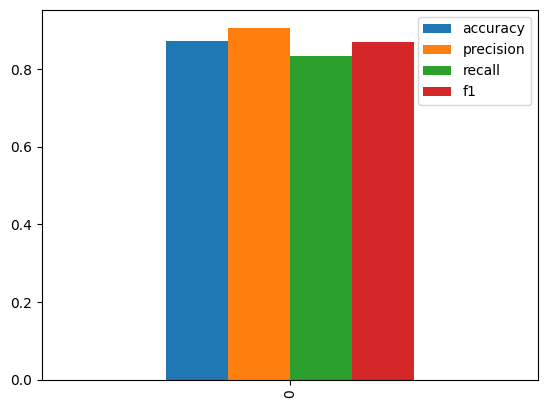

In [8]:
test_score.plot.bar()

In [9]:
test_score

,accuracy,precision,recall,f1
0,0.873113,0.907332,0.833489,0.868844


In [10]:
# Training logistic regression model
# Train RF model
lin_classifiers, lin_classifier_metrics, lin_test_df = training_pipeline(all_activity_df, 
                                                                         classifier_type = "LIN", n=10)

In [11]:
# RF classifier metrics on validation data (during training of each model)
lin_classifier_metrics

,accuracy,precision,recall,f1
0,0.746314,0.962046,0.509170,0.665905
1,0.729626,0.952984,0.463093,0.623300
2,0.730816,0.945750,0.452422,0.612054
3,0.726334,0.955117,0.465442,0.625882
4,0.713305,0.936330,0.440917,0.599520
5,0.736888,0.975133,0.482850,0.645882
6,0.713144,0.968692,0.455411,0.619552
7,0.724868,0.958029,0.466252,0.627240
8,0.700000,0.921325,0.398032,0.555903
9,0.741197,0.964225,0.499559,0.658140


In [12]:
test_score = score_activity_classifier(lin_test_df, lin_classifiers)

<AxesSubplot: >

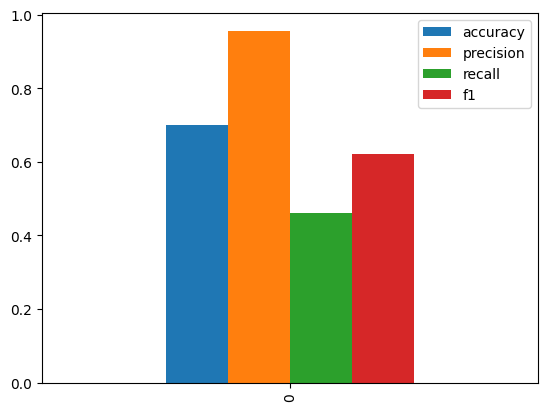

In [13]:
test_score.plot.bar()

In [14]:
test_score

,accuracy,precision,recall,f1
0,0.699957,0.957096,0.461416,0.622652


In [38]:
rf_classifiers[0].steps[2][1]

RandomForestClassifier()

In [46]:
# Feature importances (based on only one of the 10 classifiers)
all_cols = ['ACTIONS_CRM_CONTACTS_LAG_2', 'ACTIONS_CRM_CONTACTS_LAG_1',
       'ACTIONS_CRM_CONTACTS_CURR', 'ACTIONS_CRM_COMPANIES_LAG_2',
       'ACTIONS_CRM_COMPANIES_LAG_1', 'ACTIONS_CRM_COMPANIES_CURR',
       'ACTIONS_CRM_DEALS_LAG_2', 'ACTIONS_CRM_DEALS_LAG_1',
       'ACTIONS_CRM_DEALS_CURR', 'AACTIONS_EMAIL_LAG_2', 'ACTIONS_EMAIL_LAG_1',
       'ACTIONS_EMAIL_CURR']
pd.DataFrame(zip(all_cols, list(rf_classifiers[0].steps[2][1].feature_importances_)), 
             columns=["Variable", "Importance"]).sort_values("Importance", ascending=False)

,Variable,Importance
1,ACTIONS_CRM_CONTACTS_LAG_1,0.241155
0,ACTIONS_CRM_CONTACTS_LAG_2,0.215175
2,ACTIONS_CRM_CONTACTS_CURR,0.175290
6,ACTIONS_CRM_DEALS_LAG_2,0.093744
8,ACTIONS_CRM_DEALS_CURR,0.070015
7,ACTIONS_CRM_DEALS_LAG_1,0.060290
4,ACTIONS_CRM_COMPANIES_LAG_1,0.043736
5,ACTIONS_CRM_COMPANIES_CURR,0.036250
3,ACTIONS_CRM_COMPANIES_LAG_2,0.035925
10,ACTIONS_EMAIL_LAG_1,0.010849


In [44]:
pd.DataFrame(zip(all_cols, list(lin_classifiers[0].steps[2][1].coef_[0])), 
            columns=["Variable", "Importance"]).sort_values("Importance", ascending=False)

,Variable,Importance
6,ACTIONS_CRM_DEALS_LAG_2,5.446921
7,ACTIONS_CRM_DEALS_LAG_1,5.311500
4,ACTIONS_CRM_COMPANIES_LAG_1,5.062887
8,ACTIONS_CRM_DEALS_CURR,5.010819
3,ACTIONS_CRM_COMPANIES_LAG_2,3.975676
1,ACTIONS_CRM_CONTACTS_LAG_1,3.414808
5,ACTIONS_CRM_COMPANIES_CURR,3.314077
2,ACTIONS_CRM_CONTACTS_CURR,3.276706
0,ACTIONS_CRM_CONTACTS_LAG_2,2.673769
10,ACTIONS_EMAIL_LAG_1,1.968379


In [16]:
# Run the predictions on all free customers
predictions_df = prediction_pipeline(all_activity_df, rf_classifiers)

processed 100 IDs
processed 200 IDs
processed 300 IDs
processed 400 IDs
processed 500 IDs
processed 600 IDs
processed 700 IDs
processed 800 IDs
processed 900 IDs
processed 1000 IDs
processed 1100 IDs
processed 1200 IDs
processed 1300 IDs
processed 1400 IDs
processed 1500 IDs
processed 1600 IDs
processed 1700 IDs
processed 1800 IDs
processed 1900 IDs
processed 2000 IDs
processed 2100 IDs
processed 2200 IDs
processed 2300 IDs
processed 2400 IDs
processed 2500 IDs
processed 2600 IDs
processed 2700 IDs
processed 2800 IDs
processed 2900 IDs
processed 3000 IDs
processed 3100 IDs
processed 3200 IDs
processed 3300 IDs


In [18]:
predictions_df.sort_values(by="premium_activity_probability", ascending=False)

,id,prediction,premium_activity_probability
289,661,PREMIUM,1.0
2489,3903,PREMIUM,1.0
1444,2366,PREMIUM,1.0
1137,1901,PREMIUM,1.0
328,712,PREMIUM,1.0
...,...,...,...
1143,1907,FREE,0.0
1144,1909,FREE,0.0
1145,1910,FREE,0.0
1146,1911,FREE,0.0


In [19]:
predictions_df[predictions_df["prediction"]=='PREMIUM'].sort_values(by="premium_activity_probability", ascending=False)

,id,prediction,premium_activity_probability
1719,2770,PREMIUM,1.0
820,1435,PREMIUM,1.0
2961,4611,PREMIUM,1.0
1137,1901,PREMIUM,1.0
2719,4228,PREMIUM,1.0
...,...,...,...
1925,3075,PREMIUM,0.6
290,662,PREMIUM,0.6
3258,5030,PREMIUM,0.6
84,351,PREMIUM,0.6


In [21]:
all_activity_df[all_activity_df["id"]==3075].sort_values(by="DATE")

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
11179,3075,1589078.0,6 to 10,NaN,0.0,2019-01-14,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,FREE
11180,3075,1589078.0,6 to 10,NaN,0.0,2019-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE
11181,3075,1589078.0,6 to 10,NaN,0.0,2019-01-28,36.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,FREE
11182,3075,1589078.0,6 to 10,NaN,0.0,2019-02-04,11.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,FREE
11183,3075,1589078.0,6 to 10,NaN,0.0,2019-02-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,FREE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11258,3075,1589078.0,6 to 10,NaN,0.0,2020-07-20,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,FREE
11259,3075,1589078.0,6 to 10,NaN,0.0,2020-07-27,26.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,FREE
11260,3075,1589078.0,6 to 10,NaN,0.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,FREE
11261,3075,1589078.0,6 to 10,NaN,0.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,FREE


In [29]:
predictions_df["prediction"].value_counts()

FREE       3265
PREMIUM     105
Name: prediction, dtype: int64

<AxesSubplot: xlabel='DATE'>

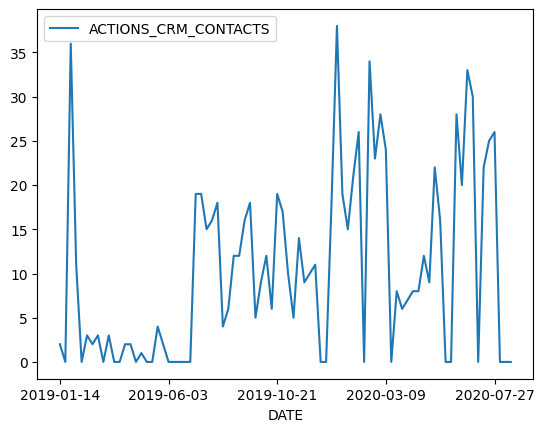

In [22]:
all_activity_df[all_activity_df["id"]==3075].sort_values(by="DATE").plot(x='DATE', 
                                                                         y='ACTIONS_CRM_CONTACTS')

In [31]:
predictions_df[predictions_df["id"]==1877]

,id,prediction,premium_activity_probability
1116,1877,FREE,0.5


<AxesSubplot: xlabel='DATE'>

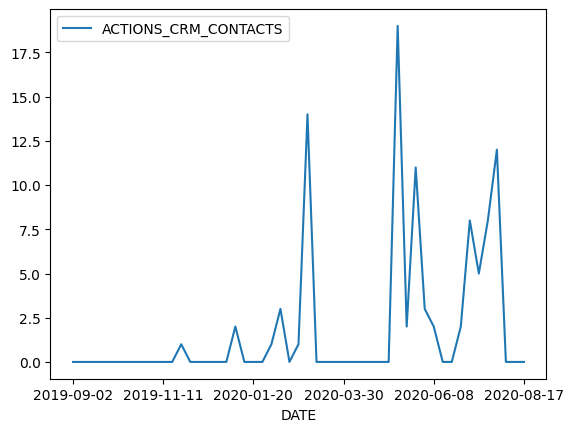

In [23]:
all_activity_df[all_activity_df["id"]==1901].sort_values(by="DATE").plot(x='DATE', 
                                                                         y='ACTIONS_CRM_CONTACTS')

In [24]:
predictions_df[predictions_df["prediction"]=='FREE'].sort_values(by="premium_activity_probability", ascending=False)

,id,prediction,premium_activity_probability
1626,2632,FREE,0.5
3096,4803,FREE,0.5
655,1199,FREE,0.5
1116,1877,FREE,0.5
2687,4189,FREE,0.5
...,...,...,...
1124,1887,FREE,0.0
1125,1889,FREE,0.0
1126,1890,FREE,0.0
1127,1891,FREE,0.0


<AxesSubplot: xlabel='DATE'>

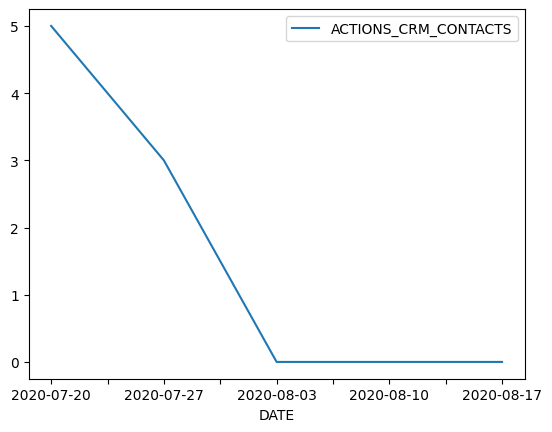

In [26]:
all_activity_df[all_activity_df["id"]==1877].sort_values(by="DATE").plot(x='DATE', 
                                                                         y='ACTIONS_CRM_CONTACTS')

<AxesSubplot: xlabel='DATE'>

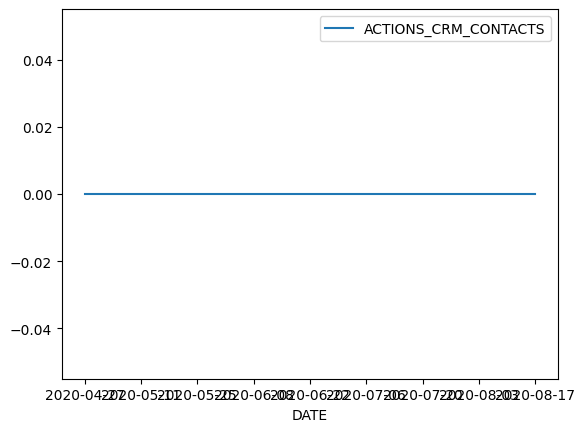

In [28]:
all_activity_df[all_activity_df["id"]==1889].sort_values(by="DATE").plot(x='DATE', 
                                                                         y='ACTIONS_CRM_CONTACTS')

# IGNORE the rest (my Dev scratch pad)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from util import transform_data, cat_to_num_plot
import util
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# file paths
customers_file = "./customers (4).csv"
non_customers_file = "./noncustomers (4).csv"
activity_file = "./usage_actions (4).csv"


In [3]:
# Read individual files
customers_df = pd.read_csv(customers_file)
non_customers_df = pd.read_csv(non_customers_file)

# Read the combined activity file. Check STEP 1 Notebook
all_activity_df = util.transform_data(customers_file,non_customers_file,activity_file)

In [4]:
all_activity_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM


### Get test data and keep it aside


In [5]:
membership_df = all_activity_df[all_activity_df["MEMBERSHIPTYPE"] != 'BEFORE-PREMIUM'][["id", "MEMBERSHIPTYPE"]].\
drop_duplicates()

In [6]:
membership_df['MEMBERSHIPTYPE'].value_counts()

FREE       3370
PREMIUM     188
Name: MEMBERSHIPTYPE, dtype: int64

### First, build a single model successfully

In [7]:
# sample FREE Ids
all_free_ids = list(membership_df[membership_df["MEMBERSHIPTYPE"] =='FREE']["id"])
all_premium_ids = list(membership_df[membership_df["MEMBERSHIPTYPE"] =='PREMIUM']["id"])
print("ALL FREE", all_free_ids[0:20])
print("ALL PREMIUM", all_premium_ids[0:20])

ALL FREE [4916, 3489, 2813, 727, 2166, 372, 1902, 3608, 4845, 3903, 3557, 4436, 3490, 1216, 4919, 995, 548, 2691, 699, 616]
ALL PREMIUM [199, 147, 118, 126, 174, 141, 197, 39, 32, 193, 178, 67, 116, 85, 54, 187, 183, 191, 25, 3]


In [8]:


# generating random samples without replacement
test_free_ids = list(np.random.choice(all_free_ids, size=30, replace=False))

# generating random samples without replacement
test_premium_ids = list(np.random.choice(all_premium_ids, size=30, replace=False))
print("test_free_ids", test_free_ids[0:20])
print("test_premium_ids", test_premium_ids[0:20])

test_free_ids [219, 1202, 3763, 2241, 552, 4263, 3197, 1462, 4498, 4570, 3728, 795, 5070, 3309, 3840, 3703, 4237, 4091, 2920, 2029]
test_premium_ids [77, 16, 115, 20, 135, 130, 193, 197, 99, 30, 26, 199, 134, 112, 58, 18, 11, 189, 124, 9]


In [9]:
train_free_ids = list(np.random.choice(list(set(all_free_ids) - set(test_free_ids)), size=150, replace=False))
print('train_free_ids',train_free_ids[0:150])

train_free_ids [1255, 2230, 2694, 1310, 2461, 3750, 1528, 2863, 1671, 3252, 3624, 4324, 4129, 4980, 1626, 4791, 2140, 1013, 5058, 3983, 3239, 2889, 1245, 3498, 2387, 908, 4788, 1482, 2220, 615, 1575, 4425, 2588, 4236, 5037, 1371, 2868, 486, 1295, 1409, 859, 3966, 2056, 757, 879, 738, 283, 3425, 4542, 1917, 3922, 3186, 5077, 4383, 3738, 296, 3855, 390, 5157, 4928, 1407, 3177, 3608, 776, 3547, 1103, 2489, 995, 3888, 2429, 4796, 2358, 4967, 3278, 469, 4022, 3038, 841, 533, 4111, 3545, 325, 3215, 4790, 1031, 4382, 342, 4833, 2249, 3569, 722, 3256, 3550, 3734, 2924, 411, 582, 914, 4891, 961, 2014, 3275, 2326, 4668, 3923, 4840, 2508, 2631, 3526, 858, 1539, 351, 3913, 2857, 223, 2587, 4431, 4524, 1967, 3043, 2749, 2159, 2004, 4233, 4462, 368, 1931, 3236, 4290, 4304, 4426, 1341, 1844, 2769, 4649, 2784, 2982, 888, 2680, 2147, 3535, 2724, 5010, 4698, 5191, 2565, 1512, 1042, 1297, 1771]


In [10]:
train_premium_ids = list(np.random.choice(list(set(all_premium_ids) - set(test_premium_ids)), size=150, replace=False))
print('train_premium_ids',train_premium_ids[0:150])


train_premium_ids [65, 2, 48, 163, 136, 110, 52, 94, 158, 57, 174, 47, 82, 54, 24, 139, 97, 5, 74, 162, 36, 123, 50, 152, 147, 84, 145, 118, 177, 146, 72, 59, 114, 176, 7, 154, 194, 183, 78, 55, 60, 111, 83, 165, 96, 184, 121, 155, 129, 80, 195, 71, 95, 81, 107, 159, 122, 70, 62, 10, 75, 175, 166, 125, 140, 3, 153, 92, 46, 89, 34, 181, 167, 53, 143, 19, 131, 161, 102, 120, 37, 6, 64, 69, 192, 148, 149, 113, 76, 126, 104, 150, 119, 133, 79, 170, 164, 28, 156, 108, 196, 4, 186, 88, 85, 33, 98, 21, 173, 178, 87, 1, 25, 105, 137, 23, 86, 168, 188, 109, 14, 179, 63, 103, 73, 42, 142, 44, 41, 169, 191, 49, 117, 17, 51, 68, 144, 141, 132, 15, 157, 91, 128, 198, 93, 12, 56, 43, 200, 45]


In [11]:
# drop id=119, as it has outliers
membership_df[membership_df["id"]==3762].head()

,id,MEMBERSHIPTYPE
43954,3762,FREE


In [12]:
membership_df[membership_df["id"]==154].head()

,id,MEMBERSHIPTYPE
5251,154,PREMIUM


In [13]:
train_df = all_activity_df[all_activity_df['id'].isin(train_premium_ids + train_free_ids)][['id','DATE','ACTIONS_CRM_CONTACTS',
                                                                                             'ACTIONS_CRM_COMPANIES',
                                                                                             'ACTIONS_CRM_DEALS',
                                                                                             'ACTIONS_EMAIL', 'MEMBERSHIPTYPE']]

train_df = train_df[train_df['MEMBERSHIPTYPE'] != 'BEFORE-PREMIUM']

In [14]:
train_df.head()

,id,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,MEMBERSHIPTYPE
96,147,2019-04-01,28.0,3.0,2.0,2.0,PREMIUM
97,147,2019-04-08,31.0,4.0,8.0,1.0,PREMIUM
98,147,2019-04-15,15.0,11.0,26.0,0.0,PREMIUM
99,147,2019-04-22,93.0,128.0,239.0,3.0,PREMIUM
100,147,2019-04-29,119.0,24.0,44.0,1.0,PREMIUM


In [15]:
train_df['MEMBERSHIPTYPE'].value_counts()

PREMIUM    6331
FREE       6133
Name: MEMBERSHIPTYPE, dtype: int64

In [16]:
test_df = all_activity_df[all_activity_df['id'].isin(test_premium_ids + test_free_ids)][['id','DATE','ACTIONS_CRM_CONTACTS',
                                                                                             'ACTIONS_CRM_COMPANIES',
                                                                                             'ACTIONS_CRM_DEALS',
                                                                                             'ACTIONS_EMAIL', 'MEMBERSHIPTYPE']]

test_df = test_df[test_df['MEMBERSHIPTYPE'] != 'BEFORE-PREMIUM']

In [17]:
test_df.head()

,id,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,MEMBERSHIPTYPE
24,199,2019-06-24,22.0,1.0,0.0,35.0,PREMIUM
25,199,2019-07-01,28.0,0.0,1.0,29.0,PREMIUM
26,199,2019-07-08,31.0,0.0,0.0,25.0,PREMIUM
27,199,2019-07-15,61.0,1.0,0.0,37.0,PREMIUM
28,199,2019-07-22,178.0,0.0,0.0,61.0,PREMIUM


In [18]:
test_df['MEMBERSHIPTYPE'].value_counts()

FREE       1278
PREMIUM    1250
Name: MEMBERSHIPTYPE, dtype: int64

In [28]:
train_df.sort_values(["id", "DATE"])[['ACTIONS_CRM_CONTACTS',
                         'ACTIONS_CRM_COMPANIES',
                         'ACTIONS_CRM_DEALS',
                         'ACTIONS_EMAIL']]

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL
3479,296.0,102.0,24.0,0.0
3480,335.0,38.0,87.0,0.0
3481,238.0,16.0,54.0,0.0
3482,158.0,16.0,43.0,0.0
3483,0.0,0.0,0.0,0.0
...,...,...,...,...
143180,0.0,0.0,0.0,0.0
143181,0.0,0.0,0.0,0.0
143182,0.0,0.0,0.0,0.0
143183,0.0,0.0,0.0,0.0


In [29]:
def get_pct_change(id, df):
    X = df[df["id"] == id].sort_values(["id", "DATE"])[['ACTIONS_CRM_CONTACTS',
                         'ACTIONS_CRM_COMPANIES',
                         'ACTIONS_CRM_DEALS',
                         'ACTIONS_EMAIL']]
    X = X+1
    X = X.pct_change()
    return X

In [31]:
train_df_pct = get_pct_change(12, train_df)
train_df_pct.head()

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL
11554,NaN,NaN,NaN,NaN
11555,-0.666667,-0.875,-0.888889,0.0
11556,1.428571,0.000,0.000000,0.0
11557,-0.411765,0.000,2.000000,0.0
11558,-0.400000,0.000,-0.666667,0.0


In [32]:
train_df_pct.shift(-1)

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL
11554,-0.666667,-0.875,-0.888889,0.0
11555,1.428571,0.000,0.000000,0.0
11556,-0.411765,0.000,2.000000,0.0
11557,-0.400000,0.000,-0.666667,0.0
11558,-0.833333,0.000,0.000000,0.0
11559,21.000000,0.000,2.000000,0.0
11560,-0.954545,0.000,-0.666667,0.0
11561,0.000000,0.000,0.000000,0.0
11562,0.000000,0.000,0.000000,0.0
11563,0.000000,0.000,0.000000,0.0


In [33]:
train_df_pct['ACTIONS_CRM_CONTACTS_LAG_2'] = train_df_pct['ACTIONS_CRM_CONTACTS']
train_df_pct['ACTIONS_CRM_CONTACTS_LAG_1'] = train_df_pct['ACTIONS_CRM_CONTACTS'].shift(-1)
train_df_pct['ACTIONS_CRM_CONTACTS_CURR'] = train_df_pct['ACTIONS_CRM_CONTACTS'].shift(-2)

In [34]:
train_df_pct.dropna(inplace=True)

In [35]:
train_df_pct.head()

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,ACTIONS_CRM_CONTACTS_LAG_2,ACTIONS_CRM_CONTACTS_LAG_1,ACTIONS_CRM_CONTACTS_CURR
11555,-0.666667,-0.875,-0.888889,0.0,-0.666667,1.428571,-0.411765
11556,1.428571,0.000,0.000000,0.0,1.428571,-0.411765,-0.400000
11557,-0.411765,0.000,2.000000,0.0,-0.411765,-0.400000,-0.833333
11558,-0.400000,0.000,-0.666667,0.0,-0.400000,-0.833333,21.000000
11559,-0.833333,0.000,0.000000,0.0,-0.833333,21.000000,-0.954545


In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


class PctTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.df_accumulator = []

    def fit(self, X, y=None):
        return self

    def get_pct_change(self, id, df):
        X = df[df["id"] == id].sort_values(["id", "DATE"])[['ACTIONS_CRM_CONTACTS',
                             'ACTIONS_CRM_COMPANIES',
                             'ACTIONS_CRM_DEALS',
                             'ACTIONS_EMAIL']]
        X = X+1
        X = X.pct_change()
        return X    
    
    def transform(self, df):
        ids = list(set(df["id"]))
        
        for id in ids:
            MEMBERSHIPTYPE = df[df["id"] == id]['MEMBERSHIPTYPE'].iloc[0]
            X = self.get_pct_change(id, df)

            X['ACTIONS_CRM_CONTACTS_LAG_2'] = X['ACTIONS_CRM_CONTACTS']
            X['ACTIONS_CRM_CONTACTS_LAG_1'] = X['ACTIONS_CRM_CONTACTS'].shift(-1)
            X['ACTIONS_CRM_CONTACTS_CURR'] = X['ACTIONS_CRM_CONTACTS'].shift(-2)   

            X['ACTIONS_CRM_COMPANIES_LAG_2'] = X['ACTIONS_CRM_COMPANIES']
            X['ACTIONS_CRM_COMPANIES_LAG_1'] = X['ACTIONS_CRM_COMPANIES'].shift(-1)
            X['ACTIONS_CRM_COMPANIES_CURR'] = X['ACTIONS_CRM_COMPANIES'].shift(-2)   
            
            X['ACTIONS_CRM_DEALS_LAG_2'] = X['ACTIONS_CRM_DEALS']
            X['ACTIONS_CRM_DEALS_LAG_1'] = X['ACTIONS_CRM_DEALS'].shift(-1)
            X['ACTIONS_CRM_DEALS_CURR'] = X['ACTIONS_CRM_DEALS'].shift(-2)   

            X['AACTIONS_EMAIL_LAG_2'] = X['ACTIONS_EMAIL']
            X['ACTIONS_EMAIL_LAG_1'] = X['ACTIONS_EMAIL'].shift(-1)
            X['ACTIONS_EMAIL_CURR'] = X['ACTIONS_EMAIL'].shift(-2)               
            
            X.drop('ACTIONS_CRM_CONTACTS', axis=1, inplace=True)
            X.drop('ACTIONS_CRM_COMPANIES', axis=1, inplace=True)
            X.drop('ACTIONS_CRM_DEALS', axis=1, inplace=True)
            X.drop('ACTIONS_EMAIL', axis=1, inplace=True)
            
            X['id'] = id
            X['MEMBERSHIPTYPE'] = MEMBERSHIPTYPE            
            X.dropna(inplace=True)
            self.df_accumulator.append(X)
        return (pd.concat(self.df_accumulator, ignore_index=True))
        

In [37]:
train_df[train_df["id"]==12]

,id,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,MEMBERSHIPTYPE
11554,12,2020-06-08,20.0,7.0,8.0,0.0,PREMIUM
11555,12,2020-06-15,6.0,0.0,0.0,0.0,PREMIUM
11556,12,2020-06-22,16.0,0.0,0.0,0.0,PREMIUM
11557,12,2020-06-29,9.0,0.0,2.0,0.0,PREMIUM
11558,12,2020-07-06,5.0,0.0,0.0,0.0,PREMIUM
11559,12,2020-07-13,0.0,0.0,0.0,0.0,PREMIUM
11560,12,2020-07-20,21.0,0.0,2.0,0.0,PREMIUM
11561,12,2020-07-27,0.0,0.0,0.0,0.0,PREMIUM
11562,12,2020-08-03,0.0,0.0,0.0,0.0,PREMIUM
11563,12,2020-08-10,0.0,0.0,0.0,0.0,PREMIUM


In [38]:
pct_transformer = PctTransformer()
pct_transformer.transform(train_df[train_df["id"]==12])
#train_df_pct = pct_transformer.transform(train_df)

,ACTIONS_CRM_CONTACTS_LAG_2,ACTIONS_CRM_CONTACTS_LAG_1,ACTIONS_CRM_CONTACTS_CURR,ACTIONS_CRM_COMPANIES_LAG_2,ACTIONS_CRM_COMPANIES_LAG_1,ACTIONS_CRM_COMPANIES_CURR,ACTIONS_CRM_DEALS_LAG_2,ACTIONS_CRM_DEALS_LAG_1,ACTIONS_CRM_DEALS_CURR,AACTIONS_EMAIL_LAG_2,ACTIONS_EMAIL_LAG_1,ACTIONS_EMAIL_CURR,id,MEMBERSHIPTYPE
0,-0.666667,1.428571,-0.411765,-0.875,0.0,0.0,-0.888889,0.000000,2.000000,0.0,0.0,0.0,12,PREMIUM
1,1.428571,-0.411765,-0.400000,0.000,0.0,0.0,0.000000,2.000000,-0.666667,0.0,0.0,0.0,12,PREMIUM
2,-0.411765,-0.400000,-0.833333,0.000,0.0,0.0,2.000000,-0.666667,0.000000,0.0,0.0,0.0,12,PREMIUM
3,-0.400000,-0.833333,21.000000,0.000,0.0,0.0,-0.666667,0.000000,2.000000,0.0,0.0,0.0,12,PREMIUM
4,-0.833333,21.000000,-0.954545,0.000,0.0,0.0,0.000000,2.000000,-0.666667,0.0,0.0,0.0,12,PREMIUM
5,21.000000,-0.954545,0.000000,0.000,0.0,0.0,2.000000,-0.666667,0.000000,0.0,0.0,0.0,12,PREMIUM
6,-0.954545,0.000000,0.000000,0.000,0.0,0.0,-0.666667,0.000000,0.000000,0.0,0.0,0.0,12,PREMIUM
7,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,12,PREMIUM


In [41]:
pct_transformer = PctTransformer()
pct_transformer.transform(train_df[train_df["id"]==102])
#train_df_pct = pct_transformer.transform(train_df)

,ACTIONS_CRM_CONTACTS_LAG_2,ACTIONS_CRM_CONTACTS_LAG_1,ACTIONS_CRM_CONTACTS_CURR,ACTIONS_CRM_COMPANIES_LAG_2,ACTIONS_CRM_COMPANIES_LAG_1,ACTIONS_CRM_COMPANIES_CURR,ACTIONS_CRM_DEALS_LAG_2,ACTIONS_CRM_DEALS_LAG_1,ACTIONS_CRM_DEALS_CURR,AACTIONS_EMAIL_LAG_2,ACTIONS_EMAIL_LAG_1,ACTIONS_EMAIL_CURR,id,MEMBERSHIPTYPE
0,-0.800000,17.000000,-0.333333,-0.875000,28.000000,-0.586207,-0.888889,9.000000,-0.400000,0.000000,0.000000,0.000000,102,PREMIUM
1,17.000000,-0.333333,-0.416667,28.000000,-0.586207,-0.250000,9.000000,-0.400000,-0.833333,0.000000,0.000000,0.000000,102,PREMIUM
2,-0.333333,-0.416667,-0.857143,-0.586207,-0.250000,-0.888889,-0.400000,-0.833333,0.000000,0.000000,0.000000,0.000000,102,PREMIUM
3,-0.416667,-0.857143,0.000000,-0.250000,-0.888889,1.000000,-0.833333,0.000000,8.000000,0.000000,0.000000,0.000000,102,PREMIUM
4,-0.857143,0.000000,0.000000,-0.888889,1.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,102,PREMIUM
5,0.000000,0.000000,0.000000,1.000000,1.000000,-0.500000,8.000000,0.000000,-0.888889,0.000000,0.000000,0.000000,102,PREMIUM
6,0.000000,0.000000,0.000000,1.000000,-0.500000,-0.500000,0.000000,-0.888889,0.000000,0.000000,0.000000,0.000000,102,PREMIUM
7,0.000000,0.000000,0.000000,-0.500000,-0.500000,0.000000,-0.888889,0.000000,0.000000,0.000000,0.000000,0.000000,102,PREMIUM
8,0.000000,0.000000,4.000000,-0.500000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,2.000000,102,PREMIUM
9,0.000000,4.000000,2.800000,0.000000,1.000000,0.500000,0.000000,6.000000,-0.142857,0.000000,2.000000,-0.666667,102,PREMIUM


In [42]:
train_df[train_df["id"]==100]

,id,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,MEMBERSHIPTYPE


In [43]:
pct_transformer = PctTransformer()
#pct_transformer.transform(train_df[train_df["id"]==199])
train_df_pct = pct_transformer.transform(train_df)

In [45]:
train_df_pct[train_df_pct["id"]==12]

,ACTIONS_CRM_CONTACTS_LAG_2,ACTIONS_CRM_CONTACTS_LAG_1,ACTIONS_CRM_CONTACTS_CURR,ACTIONS_CRM_COMPANIES_LAG_2,ACTIONS_CRM_COMPANIES_LAG_1,ACTIONS_CRM_COMPANIES_CURR,ACTIONS_CRM_DEALS_LAG_2,ACTIONS_CRM_DEALS_LAG_1,ACTIONS_CRM_DEALS_CURR,AACTIONS_EMAIL_LAG_2,ACTIONS_EMAIL_LAG_1,ACTIONS_EMAIL_CURR,id,MEMBERSHIPTYPE
439,-0.666667,1.428571,-0.411765,-0.875,0.0,0.0,-0.888889,0.000000,2.000000,0.0,0.0,0.0,12,PREMIUM
440,1.428571,-0.411765,-0.400000,0.000,0.0,0.0,0.000000,2.000000,-0.666667,0.0,0.0,0.0,12,PREMIUM
441,-0.411765,-0.400000,-0.833333,0.000,0.0,0.0,2.000000,-0.666667,0.000000,0.0,0.0,0.0,12,PREMIUM
442,-0.400000,-0.833333,21.000000,0.000,0.0,0.0,-0.666667,0.000000,2.000000,0.0,0.0,0.0,12,PREMIUM
443,-0.833333,21.000000,-0.954545,0.000,0.0,0.0,0.000000,2.000000,-0.666667,0.0,0.0,0.0,12,PREMIUM
444,21.000000,-0.954545,0.000000,0.000,0.0,0.0,2.000000,-0.666667,0.000000,0.0,0.0,0.0,12,PREMIUM
445,-0.954545,0.000000,0.000000,0.000,0.0,0.0,-0.666667,0.000000,0.000000,0.0,0.0,0.0,12,PREMIUM
446,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,12,PREMIUM


In [46]:
train_df_pct

,ACTIONS_CRM_CONTACTS_LAG_2,ACTIONS_CRM_CONTACTS_LAG_1,ACTIONS_CRM_CONTACTS_CURR,ACTIONS_CRM_COMPANIES_LAG_2,ACTIONS_CRM_COMPANIES_LAG_1,ACTIONS_CRM_COMPANIES_CURR,ACTIONS_CRM_DEALS_LAG_2,ACTIONS_CRM_DEALS_LAG_1,ACTIONS_CRM_DEALS_CURR,AACTIONS_EMAIL_LAG_2,ACTIONS_EMAIL_LAG_1,ACTIONS_EMAIL_CURR,id,MEMBERSHIPTYPE
0,0.131313,-0.288690,-0.334728,-0.621359,-0.564103,0.000000,2.520000,-0.375000,-0.200000,0.0,0.0,0.0,1,PREMIUM
1,-0.288690,-0.334728,-0.993711,-0.564103,0.000000,-0.941176,-0.375000,-0.200000,-0.977273,0.0,0.0,0.0,1,PREMIUM
2,-0.334728,-0.993711,199.000000,0.000000,-0.941176,13.000000,-0.200000,-0.977273,31.000000,0.0,0.0,4.0,1,PREMIUM
3,-0.993711,199.000000,-0.295000,-0.941176,13.000000,-0.071429,-0.977273,31.000000,-0.343750,0.0,4.0,-0.8,1,PREMIUM
4,199.000000,-0.295000,0.035461,13.000000,-0.071429,0.923077,31.000000,-0.343750,-0.428571,4.0,-0.8,0.0,1,PREMIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1528,FREE
11560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1528,FREE
11561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1528,FREE
11562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1528,FREE


In [47]:
X_train, X_test, X_validation, y_train, y_test, y_validation = util.split_into_three_parts(train_df_pct, test=0.2, validation=0.2, dependent_var='MEMBERSHIPTYPE', 
                       stratify_var='MEMBERSHIPTYPE')

Shapes of the objects:
----------------------
Shape of X_train: (7400, 13)
Shape of y_train: (7400,)
Shape of X_test: (2313, 13)
Shape of y_test: (2313,)
Shape of X_validation: (1851, 13)
Shape of y_validation: (1851,)


In [48]:
X_train.drop("id", inplace=True, axis=1)
X_test.drop("id", inplace=True, axis=1)
X_validation.drop("id", inplace=True, axis=1)

In [49]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([("num_imputer", SimpleImputer(strategy="median")),
                         ("std_scaler", StandardScaler())
                        ])

In [50]:
X_train_transformed = num_pipeline.fit_transform(X_train)

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()

In [52]:
rf_clf.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [62]:
X_validation_transformed = num_pipeline.transform(X_validation)
y_validation_predict = rf_clf.predict(X_validation_transformed)
y_validation_predict_prob = rf_clf.predict_proba(X_validation_transformed)

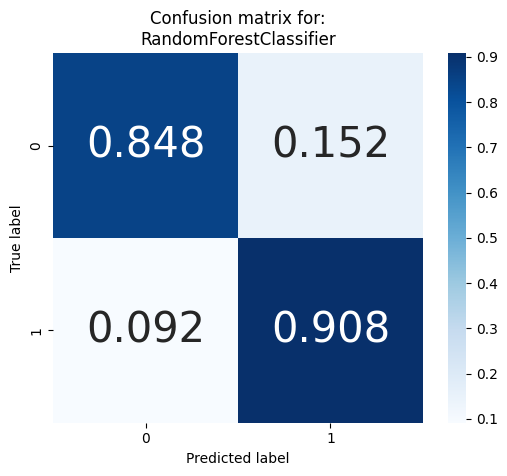

In [54]:
util.plot_confusion_matrix(model=rf_clf, predictions=y_validation_predict, true_labels=y_validation)

In [55]:
def plot_confusion_matrix(model=None, predictions=None, true_labels=None):
    cm = confusion_matrix(predictions, true_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # view with a heatmap
    sns.heatmap(cm, annot=True, annot_kws={"size": 30},
                cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if model:
        plt.title('Recall Confusion matrix for:\n{}'.format(model.__class__.__name__))
    plt.show()
    

    cm = confusion_matrix(predictions, true_labels)
    cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    # view with a heatmap
    sns.heatmap(cm, annot=True, annot_kws={"size": 30},
                cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if model:
        plt.title('Precision Confusion matrix for:\n{}'.format(model.__class__.__name__))
    plt.show()
    


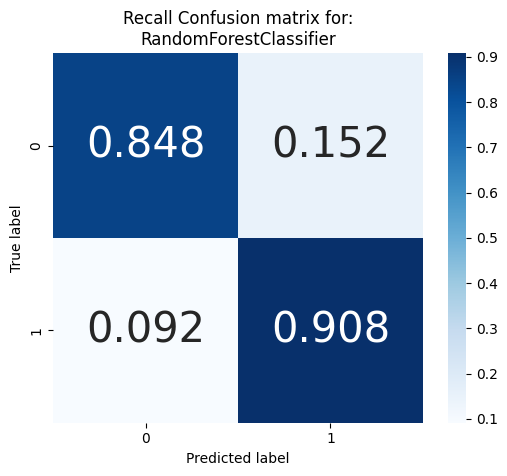

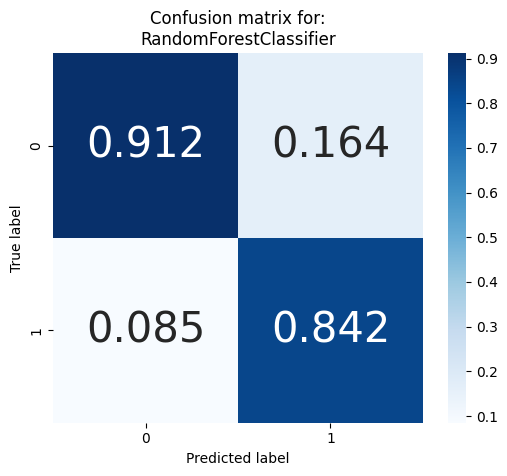

In [57]:
plot_confusion_matrix(model=rf_clf, predictions=y_validation_predict, true_labels=y_validation)

In [58]:
rf_clf.classes_

array(['FREE', 'PREMIUM'], dtype=object)

In [59]:
all_cols = ['ACTIONS_CRM_CONTACTS_LAG_2', 'ACTIONS_CRM_CONTACTS_LAG_1',
       'ACTIONS_CRM_CONTACTS_CURR', 'ACTIONS_CRM_COMPANIES_LAG_2',
       'ACTIONS_CRM_COMPANIES_LAG_1', 'ACTIONS_CRM_COMPANIES_CURR',
       'ACTIONS_CRM_DEALS_LAG_2', 'ACTIONS_CRM_DEALS_LAG_1',
       'ACTIONS_CRM_DEALS_CURR', 'AACTIONS_EMAIL_LAG_2', 'ACTIONS_EMAIL_LAG_1',
       'ACTIONS_EMAIL_CURR']
pd.DataFrame(zip(all_cols, list(rf_clf.feature_importances_)), 
             columns=["Variable", "importance"]).sort_values("importance", ascending=False)

In [60]:
pd.DataFrame(zip(all_cols, list(rf_clf.feature_importances_)), 
             columns=["Variable", "importance"]).sort_values("importance", ascending=False)

,Variable,importance
0,ACTIONS_CRM_CONTACTS_LAG_2,0.207874
1,ACTIONS_CRM_CONTACTS_LAG_1,0.201715
2,ACTIONS_CRM_CONTACTS_CURR,0.144947
7,ACTIONS_CRM_DEALS_LAG_1,0.103199
6,ACTIONS_CRM_DEALS_LAG_2,0.100831
8,ACTIONS_CRM_DEALS_CURR,0.074655
3,ACTIONS_CRM_COMPANIES_LAG_2,0.052518
4,ACTIONS_CRM_COMPANIES_LAG_1,0.042127
5,ACTIONS_CRM_COMPANIES_CURR,0.035816
9,AACTIONS_EMAIL_LAG_2,0.015500


In [64]:
y_validation_predict_prob

array([[0.13      , 0.87      ],
       [0.34      , 0.66      ],
       [0.85315913, 0.14684087],
       ...,
       [0.06      , 0.94      ],
       [0.85315913, 0.14684087],
       [0.        , 1.        ]])

In [65]:
y_validation_predict

array(['PREMIUM', 'PREMIUM', 'FREE', ..., 'PREMIUM', 'FREE', 'PREMIUM'],
      dtype=object)

In [70]:
util.get_classifier_scores(y_validation, y_validation_predict, 
                           list(zip(*y_validation_predict_prob))[1], 
                           pos_label="PREMIUM")

Accuracy     0.876283
Precision    0.908257
Recall       0.841658
F1 Score     0.873690
ROC AUC      0.908448
PR AUC       0.907990
dtype: float64

### Developing 50 Random Forest Classifiers

In [71]:
import util

In [72]:
train_df, test_df = util.activity_classifier_test_train_split(all_activity_df)

train_free_ids [3526, 1491, 3537, 771, 3853, 441, 1655, 4885, 720, 1527, 1833, 633, 3742, 573, 4997, 1168, 1176, 2058, 4357, 5108, 2286, 4219, 2594, 1938, 2063, 2190, 761, 4791, 4265, 2596, 2268, 627, 4634, 3054, 227, 4647, 3513, 2332, 1961, 3373, 4155, 3182, 1438, 2636, 1484, 3887, 1626, 1295, 1764, 2863, 957, 1378, 1478, 3939, 2879, 682, 1196, 3250, 2283, 1281, 2937, 2956, 4235, 4322, 1743, 429, 3668, 4205, 1733, 1198, 3978, 2120, 1882, 972, 779, 3100, 466, 4972, 4488, 3012, 2511, 3958, 4376, 1245, 2955, 3780, 4485, 3739, 1146, 5115, 3472, 4104, 4209, 2423, 2188, 2313, 4281, 2809, 3637, 2726, 1267, 1985, 4839, 3959, 4826, 3228, 448, 372, 3627, 1079, 2880, 3634, 3194, 1529, 3689, 3769, 2824, 4889, 739, 3009, 4144, 3928, 5184, 3409, 4642, 1340, 1439, 1143, 575, 1315, 701, 2508, 4937, 2630, 4305, 853, 2482, 4770, 4704, 322, 2910, 1182, 2172, 2388, 3666, 2333, 2813, 3264, 1572, 2122]
train_premium_ids [178, 64, 168, 126, 158, 109, 114, 123, 195, 152, 50, 1, 110, 196, 29, 175, 191, 84, 34

In [73]:
train_df["MEMBERSHIPTYPE"].value_counts()

FREE       6507
PREMIUM    6397
Name: MEMBERSHIPTYPE, dtype: int64

In [74]:
test_df["MEMBERSHIPTYPE"].value_counts()

FREE       1188
PREMIUM    1084
Name: MEMBERSHIPTYPE, dtype: int64

In [75]:
train_df, test_df = util.activity_classifier_test_train_split(all_activity_df)

train_free_ids [1929, 2659, 1099, 4331, 2444, 2067, 2174, 1959, 1169, 916, 2683, 5050, 3313, 4411, 352, 4808, 932, 3647, 5027, 4253, 3386, 5080, 354, 3388, 2088, 440, 4770, 838, 3126, 3458, 3226, 2780, 2477, 5032, 2022, 3371, 1102, 2753, 5095, 4861, 968, 3581, 659, 1853, 4414, 4968, 5161, 3530, 576, 2772, 3962, 5102, 679, 470, 1869, 4864, 1262, 1037, 2038, 1607, 1857, 332, 1301, 4498, 3113, 894, 1423, 1283, 1435, 3182, 1889, 1670, 2280, 3017, 3128, 4856, 2122, 2268, 3059, 2374, 3459, 2937, 1476, 3849, 2151, 4194, 5150, 1777, 2989, 4534, 4685, 3318, 952, 4917, 1394, 4163, 3877, 2856, 4765, 569, 3939, 1901, 3899, 4316, 5113, 2105, 523, 3478, 3021, 806, 3992, 2315, 2907, 3621, 861, 5061, 3579, 1977, 2037, 5013, 4514, 1833, 948, 1710, 3353, 522, 4030, 4647, 2011, 4142, 4096, 3241, 1430, 1470, 1268, 3988, 3418, 1958, 1170, 328, 4077, 3651, 510, 4629, 4630, 2983, 4258, 4050, 4841, 1664]
train_premium_ids [21, 164, 199, 173, 117, 111, 150, 14, 183, 200, 126, 166, 97, 133, 167, 37, 54, 169, 17

In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def create_activity_classifiers(df, dependent_var, classifier, n):
    classifiers = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(
                df.drop(dependent_var, axis=1), df[dependent_var],
                test_size=0.2,
                stratify=df[dependent_var],
                random_state=n*10)
    
        X_train.drop("id", inplace=True, axis=1)
        X_test.drop("id", inplace=True, axis=1)    
    
        num_pipeline = Pipeline([("num_imputer", SimpleImputer(strategy="median")),
                         ("std_scaler", StandardScaler())
                        ])    
        
    
        transformation_pipeline = Pipeline([("num_pipeline", num_pipeline), ("clf", classifier)])
    
        model = transformation_pipeline.fit(X_train, y_train)
    
        classifiers.append(model)
    
        y_test_predictions = model.predict(X_test)
    
        accuracy.append(accuracy_score(y_test, y_test_predictions))
    
        precision.append(precision_score(
            y_test, y_test_predictions, pos_label="PREMIUM"))
    
        recall.append(recall_score(
            y_test, y_test_predictions, pos_label="PREMIUM"))
    
        f1.append(f1_score(y_test, y_test_predictions, pos_label="PREMIUM"))
    
    return classifiers, pd.DataFrame(zip(accuracy, precision, recall, f1), columns = ['accuracy',
                                                                 'precision',
                                                                 'recall',
                                                                 'f1'])
    
    
    
    

In [84]:
pct_transformer = PctTransformer()
#pct_transformer.transform(train_df[train_df["id"]==199])
test_df_pct = pct_transformer.transform(test_df)

In [85]:
test_df_pct

,ACTIONS_CRM_CONTACTS_LAG_2,ACTIONS_CRM_CONTACTS_LAG_1,ACTIONS_CRM_CONTACTS_CURR,ACTIONS_CRM_COMPANIES_LAG_2,ACTIONS_CRM_COMPANIES_LAG_1,ACTIONS_CRM_COMPANIES_CURR,ACTIONS_CRM_DEALS_LAG_2,ACTIONS_CRM_DEALS_LAG_1,ACTIONS_CRM_DEALS_CURR,AACTIONS_EMAIL_LAG_2,ACTIONS_EMAIL_LAG_1,ACTIONS_EMAIL_CURR,id,MEMBERSHIPTYPE
0,-0.991736,0.000000,13.000000,-0.750000,0.000000,21.000000,-0.991379,0.000000,68.000000,0.0,0.0,0.0,129,PREMIUM
1,0.000000,13.000000,-0.928571,0.000000,21.000000,-0.954545,0.000000,68.000000,-0.985507,0.0,0.0,0.0,129,PREMIUM
2,13.000000,-0.928571,159.000000,21.000000,-0.954545,19.000000,68.000000,-0.985507,55.000000,0.0,0.0,0.0,129,PREMIUM
3,-0.928571,159.000000,-0.487500,-0.954545,19.000000,0.000000,-0.985507,55.000000,-0.142857,0.0,0.0,0.0,129,PREMIUM
4,159.000000,-0.487500,-0.987805,19.000000,0.000000,-0.950000,55.000000,-0.142857,-0.979167,0.0,0.0,0.0,129,PREMIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1021,FREE
2376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1021,FREE
2377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1021,FREE
2378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1021,FREE


In [86]:
def score_activity_classifier(df, classifiers):
    pct_transformer = PctTransformer()
    #pct_transformer.transform(train_df[train_df["id"]==199])
    test_df_pct = pct_transformer.transform(df)

    id = list(test_df_pct["id"])
    
    actual_labels = list(test_df_pct["MEMBERSHIPTYPE"])
    
    # test_df_pct.drop(["id", "MEMBERSHIPTYPE"], inplace=True)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for i in range(len(classifiers)):
        predicted_labels = classifiers[i].predict(test_df_pct.drop(["id", "MEMBERSHIPTYPE"], axis=1))

        accuracy.append(accuracy_score(actual_labels, predicted_labels))
    
        precision.append(precision_score(
            actual_labels, predicted_labels, pos_label="PREMIUM"))
    
        recall.append(recall_score(
            actual_labels, predicted_labels, pos_label="PREMIUM"))
    
        f1.append(f1_score(actual_labels, predicted_labels, pos_label="PREMIUM"))
        
    return pd.DataFrame(zip(accuracy, precision, recall, f1), columns = ['accuracy',
                                                                 'precision',
                                                                 'recall',
                                                                 'f1'])
            
        
        
    
    
    
    

In [87]:

test_df[test_df["id"]==2503].iloc[-1:,:]
test_df[test_df["id"]==178].iloc[-1:,:]

,id,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,MEMBERSHIPTYPE


In [88]:
  
def activity_predictor(id, all_activity_df, classifiers):
    df = all_activity_df[['id','DATE',
        'ACTIONS_CRM_CONTACTS','ACTIONS_CRM_COMPANIES','ACTIONS_CRM_DEALS',
        'ACTIONS_EMAIL','MEMBERSHIPTYPE']]
    df = df[df["id"]==id]
    pct_transformer = PctTransformer() 
    df_pct = pct_transformer.transform(df)
    predicted_label = {"PREMIUM":0, "FREE":0}
    for model in classifiers:
        label = model.predict(
            df_pct.iloc[-1:,:].drop(["id", "MEMBERSHIPTYPE"], axis=1))
        predicted_label[label[0]] += 1
    prob = predicted_label['PREMIUM']/(predicted_label['FREE'] + predicted_label['PREMIUM'])
    if prob > 0.5:
        return 'PREMIUM', prob
    else:
        return 'FREE', prob

        
        
        
        
        
    

In [189]:
len(all_free_ids)

3370

In [172]:
#set(all_activity_df[all_activity_df["MEMBERSHIPTYPE"] == "FREE"]["id"])
ids, labels, probs = [], [], []
i = 0
for id in all_free_ids:
    label, prob = activity_predictor(id, all_activity_df, rf_classifiers)
    labels.append(label)
    probs.append(prob) 
    ids.append(id)
    i += 1
    if i%100 == 0:
        print(f'processed {i} IDs')

processed 100 IDs
processed 200 IDs
processed 300 IDs
processed 400 IDs
processed 500 IDs
processed 600 IDs
processed 700 IDs
processed 800 IDs
processed 900 IDs
processed 1000 IDs
processed 1100 IDs
processed 1200 IDs
processed 1300 IDs
processed 1400 IDs
processed 1500 IDs
processed 1600 IDs
processed 1700 IDs
processed 1800 IDs
processed 1900 IDs
processed 2000 IDs
processed 2100 IDs
processed 2200 IDs
processed 2300 IDs
processed 2400 IDs
processed 2500 IDs
processed 2600 IDs
processed 2700 IDs
processed 2800 IDs
processed 2900 IDs
processed 3000 IDs
processed 3100 IDs
processed 3200 IDs
processed 3300 IDs


In [173]:
predictions = pd.DataFrame(zip(ids, labels, probs), columns=["id", "label", "prob"])

In [174]:
predictions.to_csv("activity_predictions.csv")

In [175]:
predictions.sort_values(by=["prob"], ascending=False)

,id,label,prob
1685,2227,PREMIUM,1.0
2958,2120,PREMIUM,1.0
3268,1219,PREMIUM,1.0
3269,4606,PREMIUM,1.0
2676,4809,PREMIUM,1.0
...,...,...,...
1142,1531,FREE,0.0
1143,1580,FREE,0.0
1144,3097,FREE,0.0
1145,1652,FREE,0.0


In [193]:
predictions["label"].value_counts()

FREE       3270
PREMIUM     100
Name: label, dtype: int64

In [191]:
all_activity_df[all_activity_df["id"]==4606]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
142890,4606,16000001.0,1,NaN,0.0,2020-07-06,22.0,2.0,3.0,0.0,1.0,1.0,1.0,0.0,0,FREE
142891,4606,16000001.0,1,NaN,0.0,2020-07-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,FREE
142892,4606,16000001.0,1,NaN,0.0,2020-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE
142893,4606,16000001.0,1,NaN,0.0,2020-07-27,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,FREE
142894,4606,16000001.0,1,NaN,0.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,FREE
142895,4606,16000001.0,1,NaN,0.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,FREE
142896,4606,16000001.0,1,NaN,0.0,2020-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,FREE


In [192]:
pct_transformer = PctTransformer() 
df_pct = pct_transformer.transform(all_activity_df[all_activity_df["id"]==4606])
df_pct

,ACTIONS_CRM_CONTACTS_LAG_2,ACTIONS_CRM_CONTACTS_LAG_1,ACTIONS_CRM_CONTACTS_CURR,ACTIONS_CRM_COMPANIES_LAG_2,ACTIONS_CRM_COMPANIES_LAG_1,ACTIONS_CRM_COMPANIES_CURR,ACTIONS_CRM_DEALS_LAG_2,ACTIONS_CRM_DEALS_LAG_1,ACTIONS_CRM_DEALS_CURR,AACTIONS_EMAIL_LAG_2,ACTIONS_EMAIL_LAG_1,ACTIONS_EMAIL_CURR,id,MEMBERSHIPTYPE
0,-0.956522,0.0,1.0,-0.666667,0.0,1.0,-0.75,0.0,0.0,0.0,0.0,0.0,4606,FREE
1,0.000000,1.0,-0.5,0.000000,1.0,-0.5,0.00,0.0,0.0,0.0,0.0,0.0,4606,FREE
2,1.000000,-0.5,0.0,1.000000,-0.5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4606,FREE
3,-0.500000,0.0,0.0,-0.500000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4606,FREE


In [97]:
rf_clf = RandomForestClassifier()
rf_classifiers, rf_scores = create_activity_classifiers(train_df_pct, "MEMBERSHIPTYPE", rf_clf, 10)

In [98]:
rf_scores

,accuracy,precision,recall,f1
0,0.878513,0.913204,0.840986,0.875609
1,0.878513,0.912442,0.841837,0.875719
2,0.877648,0.910009,0.842687,0.875055
3,0.877648,0.911521,0.840986,0.874834
4,0.878513,0.913969,0.840136,0.875498
5,0.878080,0.913124,0.840136,0.875111
6,0.876783,0.909091,0.841837,0.874172
7,0.877216,0.912200,0.839286,0.874225
8,0.879377,0.913364,0.842687,0.876603
9,0.878080,0.910846,0.842687,0.875442


In [99]:
score_activity_classifier(test_df, rf_classifiers)

,accuracy,precision,recall,f1
0,0.880672,0.964211,0.785592,0.865784
1,0.880672,0.964211,0.785592,0.865784
2,0.880672,0.964211,0.785592,0.865784
3,0.880672,0.964211,0.785592,0.865784
4,0.880672,0.964211,0.785592,0.865784
5,0.880672,0.964211,0.785592,0.865784
6,0.880672,0.964211,0.785592,0.865784
7,0.880672,0.964211,0.785592,0.865784
8,0.880672,0.964211,0.785592,0.865784
9,0.880672,0.964211,0.785592,0.865784


In [73]:
from sklearn.linear_model import LogisticRegression
lr_l2_clf = LogisticRegression(penalty='l2')

In [74]:
lr_classifiers, lr_scores = create_classifiers(train_df_pct, "MEMBERSHIPTYPE", lr_l2_clf, 10)

In [75]:
lr_scores

,accuracy,precision,recall,f1
0,0.713922,0.947935,0.450128,0.610405
1,0.713922,0.947935,0.450128,0.610405
2,0.713922,0.947935,0.450128,0.610405
3,0.713922,0.947935,0.450128,0.610405
4,0.713922,0.947935,0.450128,0.610405
5,0.713922,0.947935,0.450128,0.610405
6,0.713922,0.947935,0.450128,0.610405
7,0.713922,0.947935,0.450128,0.610405
8,0.713922,0.947935,0.450128,0.610405
9,0.713922,0.947935,0.450128,0.610405


In [ ]:
clf = RandomForestClassifier()
classifiers, scores = create_classifiers(train_df_pct, "MEMBERSHIPTYPE", clf, 10)

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([("num_imputer", SimpleImputer(strategy="median")),
                         ("std_scaler", StandardScaler())
                        ])
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
from sklearn.compose import ColumnTransformer

In [42]:
transformation_pipeline = Pipeline([("num_pipeline", num_pipeline),("clf", rf_clf)])


In [43]:
transformation_pipeline.fit(X_train, y_train)

Pipeline(steps=[('num_pipeline',
                 Pipeline(steps=[('num_imputer',
                                  SimpleImputer(strategy='median')),
                                 ('std_scaler', StandardScaler())])),
                ('clf', RandomForestClassifier())])

In [44]:
transformation_pipeline.predict(X_test)

array(['PREMIUM', 'PREMIUM', 'FREE', ..., 'FREE', 'FREE', 'PREMIUM'],
      dtype=object)

In [194]:
y_validation_predict

array(['FREE', 'FREE', 'PREMIUM', ..., 'PREMIUM', 'FREE', 'FREE'],
      dtype=object)

In [195]:
rf_clf.predict_proba(X_validation_transformed)

array([[0.8788397, 0.1211603],
       [0.8788397, 0.1211603],
       [0.04     , 0.96     ],
       ...,
       [0.062    , 0.938    ],
       [0.8788397, 0.1211603],
       [0.8788397, 0.1211603]])

In [89]:
def get_pct_change(df):
    return df.pct_change()
get_pct_change(train_df.sort_values(["id", "DATE"])[['ACTIONS_CRM_CONTACTS',
                         'ACTIONS_CRM_COMPANIES',
                         'ACTIONS_CRM_DEALS',
                         'ACTIONS_EMAIL']])

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL
3479,NaN,NaN,NaN,NaN
3480,0.131757,-0.627451,2.625000,NaN
3481,-0.289552,-0.578947,-0.379310,NaN
3482,-0.336134,0.000000,-0.203704,NaN
3483,-1.000000,-1.000000,-1.000000,NaN
...,...,...,...,...
13361,NaN,NaN,NaN,NaN
13362,NaN,NaN,NaN,NaN
13363,NaN,NaN,NaN,NaN
13364,NaN,NaN,NaN,NaN


In [59]:
all_activity_df.columns

Index(['id', 'ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY', 'MRR', 'DATE',
       'ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS',
       'ACTIONS_EMAIL', 'USERS_CRM_CONTACTS', 'USERS_CRM_COMPANIES',
       'USERS_CRM_DEALS', 'USERS_EMAIL', 'LASTUSED', 'MEMBERSHIPTYPE',
       'Cluster', 'cluster'],
      dtype='object')

In [60]:
all_activity_numeric = all_activity_df[['ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS',
       'ACTIONS_EMAIL', 'USERS_CRM_CONTACTS', 'USERS_CRM_COMPANIES',
       'USERS_CRM_DEALS', 'USERS_EMAIL', 'LASTUSED']]

In [61]:
## The std scaler is not giving good results for PCA

#std_scaler = StandardScaler()
#std_scaler.fit(all_activity_numeric)
#df = pd.DataFrame(std_scaler.transform(all_activity_numeric), columns=[['ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS',
#       'ACTIONS_EMAIL', 'USERS_CRM_CONTACTS', 'USERS_CRM_COMPANIES',
#       'USERS_CRM_DEALS', 'USERS_EMAIL', 'LASTUSED']])
df = all_activity_numeric

In [62]:
df.head()

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED
0,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0
3,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0
4,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0


In [63]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(random_state=42)
pca.fit(df)
print(pca.explained_variance_ratio_)

[5.25578694e-01 3.22248408e-01 1.20429071e-01 3.15164897e-02
 1.44685429e-04 5.75198821e-05 1.37276743e-05 1.04608686e-05
 9.43098291e-07]


In [64]:
np.array(pca.explained_variance_ratio_*100).cumsum()

array([ 52.55786944,  84.78271025,  96.82561733,  99.9772663 ,
        99.99173485,  99.99748684,  99.9988596 ,  99.99990569,
       100.        ])

,Component,Cumulative Explained Variance
0,1,52.557869
1,2,84.782710
2,3,96.825617
3,4,99.977266
4,5,99.991735
5,6,99.997487
6,7,99.998860
7,8,99.999906
8,9,100.000000


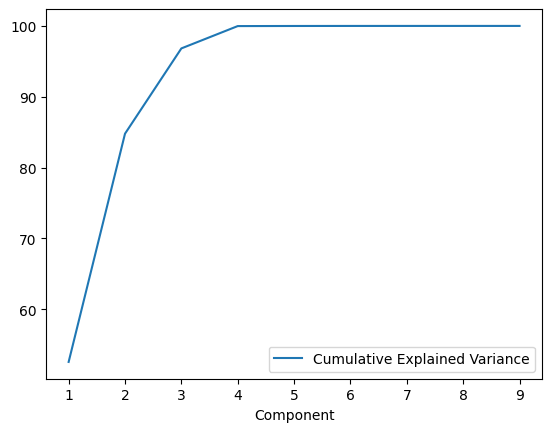

In [65]:
explained_variance_df = pd.DataFrame(zip(range(1, len(pca.explained_variance_ratio_)+1), np.array(pca.explained_variance_ratio_*100).cumsum()),
            columns=["Component", "Cumulative Explained Variance"])

explained_variance_df.plot.line(x = "Component", y= "Cumulative Explained Variance")
explained_variance_df

## Inference
* The first 3 PCA components are capturing almost 98% of the variance

Now fit the PCA with 3 components only.

In [66]:
pca = PCA(n_components=3,copy=True,random_state=42)
pca.fit(df)

# Transform the data using the fitted PCA
reduced_df = pca.transform(df)

In [67]:
reduced_df = pd.DataFrame(reduced_df, columns=["Dim_1", "Dim_2", "Dim_3"])

In [68]:
reduced_df

,Dim_1,Dim_2,Dim_3
0,66.250005,-103.500519,-17.011491
1,6.166073,-107.746397,-5.740718
2,27.842604,-110.811604,-9.512179
3,112.351561,-94.938288,-22.207276
4,118.432884,-93.831407,-21.434959
...,...,...,...
155095,3.658636,-93.981770,-5.304378
155096,7.419792,-114.628710,-5.958887
155097,6.166073,-107.746397,-5.740718
155098,4.912354,-100.864084,-5.522548


In [69]:
reduced_df['MEMBERSHIPTYPE'] = list(all_activity_df['MEMBERSHIPTYPE'])
reduced_df['id'] = list(all_activity_df['id'])

In [70]:
reduced_df

,Dim_1,Dim_2,Dim_3,MEMBERSHIPTYPE,id
0,66.250005,-103.500519,-17.011491,BEFORE-PREMIUM,199
1,6.166073,-107.746397,-5.740718,BEFORE-PREMIUM,199
2,27.842604,-110.811604,-9.512179,BEFORE-PREMIUM,199
3,112.351561,-94.938288,-22.207276,BEFORE-PREMIUM,199
4,118.432884,-93.831407,-21.434959,BEFORE-PREMIUM,199
...,...,...,...,...,...
155095,3.658636,-93.981770,-5.304378,FREE,4011
155096,7.419792,-114.628710,-5.958887,FREE,3104
155097,6.166073,-107.746397,-5.740718,FREE,3104
155098,4.912354,-100.864084,-5.522548,FREE,3104


In [71]:
colors = {'BEFORE-PREMIUM':'blue', 'FREE':'red', 'PREMIUM':'green'}


In [72]:
#reduced_df.plot.scatter(x="Dim_1", y = "Dim_2", c=reduced_df['MEMBERSHIPTYPE'].map(colors), 
#                        label=colors)

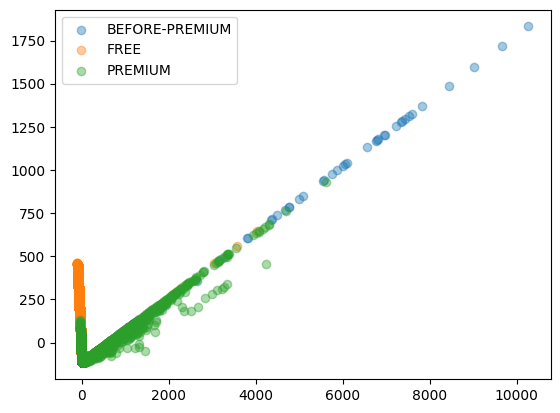

In [73]:
fig,ax = plt.subplots()
for k,d in reduced_df.groupby('MEMBERSHIPTYPE'):
    ax.scatter(d['Dim_1'], d['Dim_2'], label=k, alpha=0.4)
plt.legend(loc=2)
# plt.savefig('scatter.png')
plt.show()

### Inference
* There is a clear distinction between the three groups. 
* We should use clustering algorithm to cluster the data
* After clustering we can get the following insights:
    * Since we are NOT using MEMBERSHIPTYPE in the PCA, we can analyze how many user actions belong to a PREMIUM vs BEFORE-PAID vs FREE members
    * We can check the individual customers activity, and understand why they are classified (or mis-classified) into a specific cluster.
    * Finally the clusters can be used to identify existing PAID customers who are assigned to a cluster with most of the FREE members activity. Such customers may be at the verge of canceling their membership

### Clustering

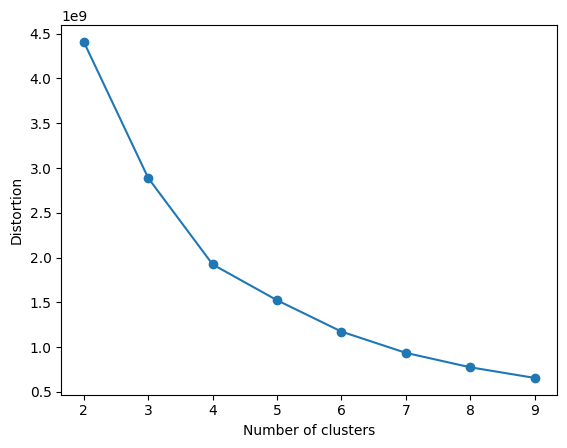

In [74]:
from sklearn.cluster import KMeans

distortions=[]
n_clusters=range(2,10)

for i in n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=i, init='k-means++',  n_init=10, max_iter=300, tol=1e-04, random_state=42)
    clusterer.fit(reduced_df[['Dim_1','Dim_2','Dim_3']])
    
    distortions.append(clusterer.inertia_)
    
plt.plot(n_clusters, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Inference
* We should use 5 clusters to cluster our data

In [75]:
clusterer = KMeans(n_clusters=5, init='k-means++',  n_init=10, max_iter=300, tol=1e-04, random_state=0)
clusterer.fit(reduced_df[['Dim_1', 'Dim_2', 'Dim_3']])


KMeans(n_clusters=5, random_state=0)

In [76]:
preds = clusterer.predict(reduced_df[['Dim_1', 'Dim_2', 'Dim_3']])
print(preds)
cluster_labels = np.unique(preds)
print(cluster_labels)
reduced_df['cluster'] = preds
reduced_df

[0 0 0 ... 0 0 0]
[0 1 2 3 4]


,Dim_1,Dim_2,Dim_3,MEMBERSHIPTYPE,id,cluster
0,66.250005,-103.500519,-17.011491,BEFORE-PREMIUM,199,0
1,6.166073,-107.746397,-5.740718,BEFORE-PREMIUM,199,0
2,27.842604,-110.811604,-9.512179,BEFORE-PREMIUM,199,0
3,112.351561,-94.938288,-22.207276,BEFORE-PREMIUM,199,0
4,118.432884,-93.831407,-21.434959,BEFORE-PREMIUM,199,0
...,...,...,...,...,...,...
155095,3.658636,-93.981770,-5.304378,FREE,4011,0
155096,7.419792,-114.628710,-5.958887,FREE,3104,0
155097,6.166073,-107.746397,-5.740718,FREE,3104,0
155098,4.912354,-100.864084,-5.522548,FREE,3104,0


In [77]:
all_activity_df["Cluster"] = list(reduced_df["cluster"])

In [157]:
scaler = StandardScaler()
scaler.fit(reduced_df[["Dim_1", "Dim_2", "Dim_3"]])
reduced_df_scaled = scaler.transform(reduced_df[["Dim_1", "Dim_2", "Dim_3"]])


In [158]:
reduced_df_scaled = pd.DataFrame(reduced_df_scaled, columns=["Dim_1", "Dim_2", "Dim_3"])

<AxesSubplot: ylabel='Frequency'>

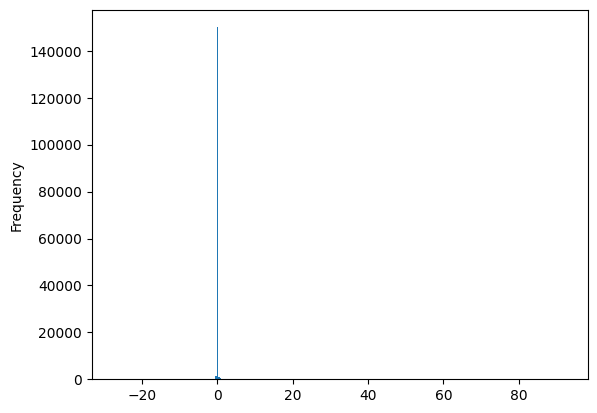

In [159]:
reduced_df_scaled["Dim_3"].plot.hist(bins=300)

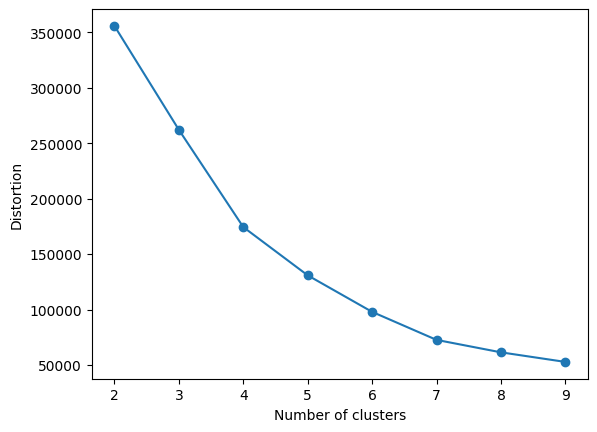

In [160]:
from sklearn.cluster import KMeans

distortions=[]
n_clusters=range(2,10)

for i in n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=i, init='k-means++',  n_init=10, max_iter=300, tol=1e-04, random_state=42)
    clusterer.fit(reduced_df_scaled[['Dim_1','Dim_2','Dim_3']])
    
    distortions.append(clusterer.inertia_)
    
plt.plot(n_clusters, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [161]:
clusterer_scaled = KMeans(n_clusters=4, init='k-means++',  n_init=10, max_iter=300, tol=1e-04, random_state=0)
clusterer_scaled.fit(reduced_df_scaled[['Dim_1', 'Dim_2', 'Dim_3']])


KMeans(n_clusters=4, random_state=0)

In [162]:
clusterer_scaled.predict(reduced_df_scaled)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [163]:
reduced_df_scaled['cluster'] = clusterer_scaled.predict(reduced_df_scaled)

In [164]:
reduced_df_scaled["id"] = list(reduced_df["id"])

In [165]:
reduced_df_scaled["MEMBERSHIPTYPE"] = list(reduced_df["MEMBERSHIPTYPE"])

In [166]:
reduced_df_scaled

,Dim_1,Dim_2,Dim_3,cluster,id,MEMBERSHIPTYPE
0,0.444613,-0.887080,-0.238502,0,199,BEFORE-PREMIUM
1,0.041381,-0.923470,-0.080485,0,199,BEFORE-PREMIUM
2,0.186856,-0.949741,-0.133361,0,199,BEFORE-PREMIUM
3,0.754007,-0.813695,-0.311347,0,199,BEFORE-PREMIUM
4,0.794820,-0.804208,-0.300519,0,199,BEFORE-PREMIUM
...,...,...,...,...,...,...
155095,0.024554,-0.805496,-0.074368,0,4011,FREE
155096,0.049795,-0.982457,-0.083544,0,3104,FREE
155097,0.041381,-0.923470,-0.080485,0,3104,FREE
155098,0.032968,-0.864483,-0.077426,0,3104,FREE


In [167]:
set(reduced_df_scaled["cluster"])

{0, 1, 2, 3}

In [168]:
reduced_df_scaled["cluster"].value_counts()

0    111918
1     43009
3       103
2        70
Name: cluster, dtype: int64

In [169]:
reduced_df_scaled[reduced_df_scaled["cluster"]==0]["MEMBERSHIPTYPE"].value_counts()

FREE              100400
PREMIUM             7671
BEFORE-PREMIUM      3847
Name: MEMBERSHIPTYPE, dtype: int64

In [170]:
reduced_df_scaled[reduced_df_scaled["cluster"]==1]["MEMBERSHIPTYPE"].value_counts()

FREE              42957
PREMIUM              41
BEFORE-PREMIUM       11
Name: MEMBERSHIPTYPE, dtype: int64

In [171]:
reduced_df_scaled[reduced_df_scaled["cluster"]==2]["MEMBERSHIPTYPE"].value_counts()

PREMIUM           68
BEFORE-PREMIUM     1
FREE               1
Name: MEMBERSHIPTYPE, dtype: int64

In [172]:
reduced_df_scaled[reduced_df_scaled["cluster"]==3]["MEMBERSHIPTYPE"].value_counts()

PREMIUM           58
BEFORE-PREMIUM    37
FREE               8
Name: MEMBERSHIPTYPE, dtype: int64

In [173]:
reduced_df_scaled[reduced_df_scaled["cluster"]==4]["MEMBERSHIPTYPE"].value_counts()

Series([], Name: MEMBERSHIPTYPE, dtype: int64)

In [174]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==0]["id"])))
#print(set(reduced_df_scaled[reduced_df_scaled["cluster"]==0]["id"]))

3568


In [175]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"])))
#print(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"]))

2035


In [176]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==2]["id"])))
#print(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"]))

4


In [177]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==3]["id"])))
#print(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"]))

12


In [178]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==4]["id"])))
#print(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"]))

0


In [179]:
all_activity_df["cluster"] = list(reduced_df_scaled["cluster"])

In [180]:
all_activity_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster,cluster
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM,0,0
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0,0
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM,0,0
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM,0,0
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM,0,0


In [181]:
all_activity_df.groupby(["cluster"]).agg({"ACTIONS_CRM_CONTACTS":"mean"})

,ACTIONS_CRM_CONTACTS
cluster,
0,12.722833
1,0.000000
2,925.014286
3,4185.543689


In [191]:
# 119 customer is really an outlier
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==0]["id"])))
print(list(set(reduced_df_scaled[reduced_df_scaled["cluster"]==0]["id"]))[0:10])

3568
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [185]:
# 119 customer is really an outlier
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"])))
print(list(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"]))[0:10])

2035
[10, 47, 77, 80, 87, 95, 144, 173, 179, 206]


In [188]:
# 119 customer is really an outlier
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==2]["id"])))
print(set(reduced_df_scaled[reduced_df_scaled["cluster"]==2]["id"]))

4
{65, 50, 4691, 148}


In [189]:
# 119 customer is really an outlier
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==3]["id"])))
print(set(reduced_df_scaled[reduced_df_scaled["cluster"]==3]["id"]))

12
{34, 67, 68, 164, 36, 39, 82, 980, 118, 5144, 187, 92}


<AxesSubplot: xlabel='DATE'>

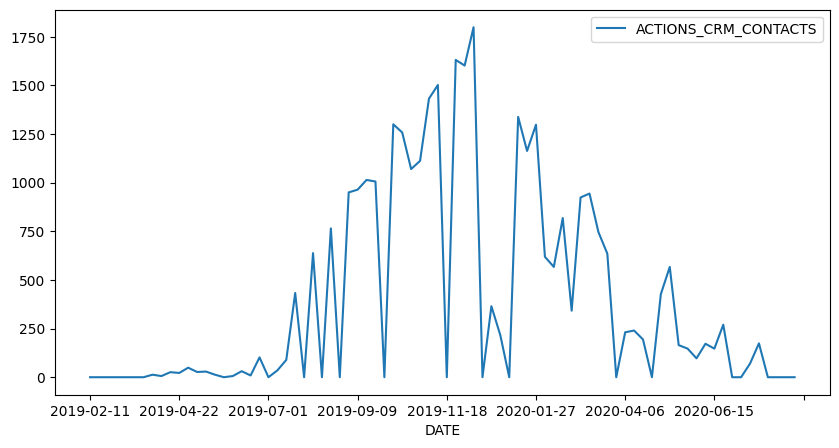

In [119]:
all_activity_df[all_activity_df["id"] == 50].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))


<AxesSubplot: xlabel='DATE'>

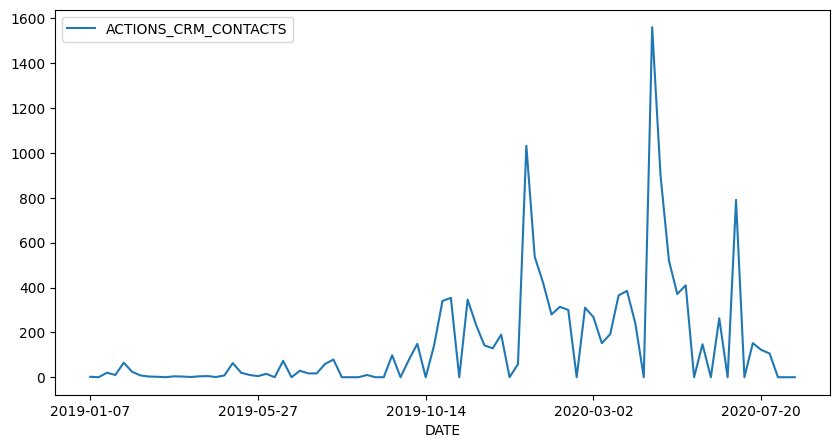

In [120]:
all_activity_df[all_activity_df["id"] == 65].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

<AxesSubplot: xlabel='DATE'>

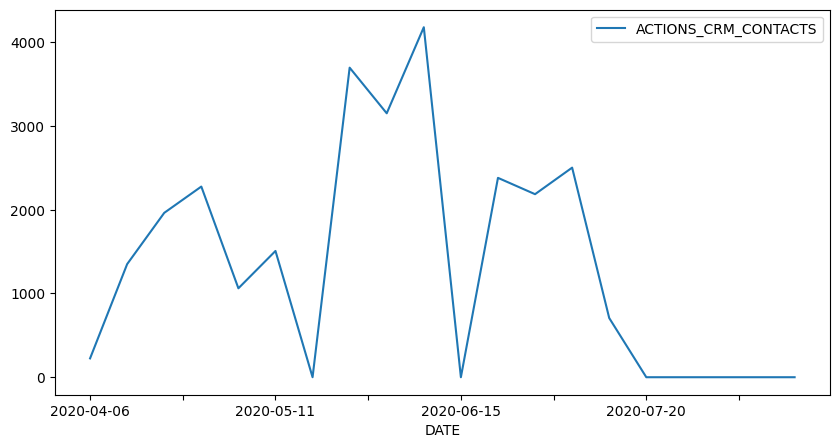

In [156]:
all_activity_df[all_activity_df["id"] == 980].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

In [51]:
all_activity_df[all_activity_df["id"]==119]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster,cluster
11231,119,1740005.0,201 to 1000,RETAIL,250.0,2020-02-03,3.0,0.0,8.0,1.0,1.0,0.0,1.0,1.0,0,BEFORE-PREMIUM,1,0
11232,119,1740005.0,201 to 1000,RETAIL,250.0,2020-02-10,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,1,0
11233,119,1740005.0,201 to 1000,RETAIL,250.0,2020-02-17,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,PREMIUM,1,0
11234,119,1740005.0,201 to 1000,RETAIL,250.0,2020-02-24,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,PREMIUM,1,0
11235,119,1740005.0,201 to 1000,RETAIL,250.0,2020-03-02,15.0,1.0,10.0,0.0,1.0,1.0,1.0,0.0,0,PREMIUM,1,0
11236,119,1740005.0,201 to 1000,RETAIL,250.0,2020-03-09,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,PREMIUM,1,0
11237,119,1740005.0,201 to 1000,RETAIL,250.0,2020-03-16,43.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,0,PREMIUM,1,0
11238,119,1740005.0,201 to 1000,RETAIL,250.0,2020-03-23,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,PREMIUM,1,0
11239,119,1740005.0,201 to 1000,RETAIL,250.0,2020-03-30,13.0,0.0,1.0,7.0,1.0,0.0,1.0,1.0,0,PREMIUM,1,0
11240,119,1740005.0,201 to 1000,RETAIL,250.0,2020-04-06,68.0,0.0,14.0,5.0,3.0,0.0,1.0,1.0,0,PREMIUM,1,0


In [47]:
set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"])

{10,
 47,
 77,
 80,
 87,
 95,
 144,
 173,
 179,
 206,
 207,
 211,
 215,
 217,
 218,
 221,
 223,
 224,
 225,
 227,
 262,
 264,
 266,
 275,
 277,
 278,
 284,
 286,
 287,
 288,
 289,
 291,
 293,
 294,
 296,
 299,
 302,
 305,
 307,
 310,
 311,
 315,
 318,
 320,
 321,
 322,
 324,
 325,
 326,
 327,
 332,
 334,
 335,
 337,
 338,
 340,
 341,
 342,
 343,
 347,
 352,
 354,
 355,
 356,
 357,
 358,
 360,
 364,
 368,
 369,
 371,
 373,
 375,
 378,
 380,
 381,
 387,
 390,
 397,
 398,
 400,
 401,
 404,
 405,
 407,
 411,
 413,
 414,
 415,
 421,
 422,
 424,
 425,
 426,
 429,
 430,
 431,
 433,
 438,
 439,
 440,
 449,
 450,
 454,
 455,
 463,
 464,
 466,
 468,
 473,
 474,
 475,
 478,
 483,
 484,
 487,
 489,
 490,
 492,
 493,
 497,
 501,
 503,
 508,
 510,
 511,
 517,
 518,
 523,
 524,
 529,
 531,
 533,
 536,
 541,
 550,
 552,
 554,
 556,
 559,
 561,
 567,
 572,
 576,
 581,
 582,
 584,
 586,
 587,
 591,
 592,
 594,
 595,
 600,
 602,
 606,
 608,
 609,
 615,
 617,
 620,
 625,
 626,
 627,
 629,
 631,
 632,
 635

## Customer Journey

In [88]:
all_activity_df.sort_values(by=["id", "DATE"]).head(50)

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
3475,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-07,46.0,1.0,2.0,6.0,3.0,1.0,1.0,1.0,0,BEFORE-PREMIUM,1
3476,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-14,213.0,10.0,74.0,10.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM,1
3477,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-21,138.0,4.0,45.0,5.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM,1
3478,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-28,208.0,61.0,87.0,7.0,4.0,2.0,3.0,1.0,0,BEFORE-PREMIUM,1
3479,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-04,296.0,102.0,24.0,0.0,4.0,4.0,2.0,0.0,0,PREMIUM,1
3480,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-11,335.0,38.0,87.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM,1
3481,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-18,238.0,16.0,54.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM,1
3482,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-25,158.0,16.0,43.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM,1
3483,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM,1
3484,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-03-11,199.0,13.0,31.0,4.0,3.0,2.0,1.0,1.0,0,PREMIUM,1


In [99]:
states = [('Start', 0),
('Start', 1),
('Start', 2),
('Start', 3),
('Start', 4),] + [(i, j) for i in [0, 1, 2, 3, 4] for j in [0, 1, 2, 3, 4]]

states = {i:0 for i in states}
states[('Start', 0)]


0

In [107]:
id = 1

prev = None
journey = {}

for _, i in all_activity_df[all_activity_df["id"] == 1].iterrows():
    if prev is None:
        key = ('Start', i.Cluster)
        states[key] += 1
        journey[id] =  [i['Cluster']]
        prev = i['Cluster']
    else:
        key = (prev, i['Cluster'])
        states[key] += 1
        journey[id].append(i['Cluster'])
        
        
        
    

In [122]:
states = None
journey = None
def state_reset():
    global states 
    states = [('Start', 0),
    ('Start', 1),
    ('Start', 2),
    ('Start', 3),
    ('Start', 4),] + [(i, j) for i in [0, 1, 2, 3, 4] for j in [0, 1, 2, 3, 4]]

    states = {i:0 for i in states}
    states[('Start', 0)]
    global journey 
    journey = {}

def simulate_customer_journey(id):
    prev = None


    for _, i in all_activity_df[all_activity_df["id"] == id].sort_values(by="DATE").iterrows():
        if prev is None:
            key = ('Start', i.Cluster)
            states[key] += 1
            journey[id] =  [i['Cluster']]
            prev = i['Cluster']
        else:
            key = (prev, i['Cluster'])
            states[key] += 1
            journey[id].append(i['Cluster'])
            prev = i['Cluster']            
        
        
        
    

In [123]:
all_customers = set(all_activity_df["id"])
state_reset()
for id in all_customers:
    simulate_customer_journey(id)
    

In [124]:
states

{('Start', 0): 0,
 ('Start', 1): 3561,
 ('Start', 2): 0,
 ('Start', 3): 7,
 ('Start', 4): 1,
 (0, 0): 40662,
 (0, 1): 362,
 (0, 2): 0,
 (0, 3): 0,
 (0, 4): 0,
 (1, 0): 2347,
 (1, 1): 107074,
 (1, 2): 3,
 (1, 3): 247,
 (1, 4): 7,
 (2, 0): 0,
 (2, 1): 3,
 (2, 2): 7,
 (2, 3): 0,
 (2, 4): 0,
 (3, 0): 0,
 (3, 1): 253,
 (3, 2): 0,
 (3, 3): 572,
 (3, 4): 5,
 (4, 0): 0,
 (4, 1): 9,
 (4, 2): 0,
 (4, 3): 4,
 (4, 4): 34}

In [165]:
states = None
journey = None
potential_conversion = None
def state_reset():
    global states 
    states = [('Start', 0),
    ('Start', 1),
    ('Start', 2),
    ('Start', 3),
    ('Start', 4),] + [(i, j) for i in [0, 1, 2, 3, 4] for j in [0, 1, 2, 3, 4]]

    states = {i:0 for i in states}
    states[('Start', 0)]
    global journey 
    journey = {}
    global potential_conversion
    potential_conversion ={}

def simulate_customer_journey(id, success_states=[3,4]):
    prev = None


    for _, i in all_activity_df[all_activity_df["id"] == id].sort_values(by="DATE").iterrows():
        if prev is None:
            key = ('Start', i.Cluster)
            states[key] += 1
            journey[id] =  [i['Cluster']]
            prev = i['Cluster']
            if i['Cluster'] in success_states:
                potential_conversion[id] = [(i['DATE'], i['Cluster'], i['MEMBERSHIPTYPE'])]
        else:
            key = (prev, i['Cluster'])
            states[key] += 1
            journey[id].append(i['Cluster'])
            prev = i['Cluster']            
            if i['Cluster'] in success_states:
                if id in potential_conversion:
                    potential_conversion[id].append((i['DATE'], i['Cluster'], i['MEMBERSHIPTYPE']))                    
                else:
                    potential_conversion[id]: [(i['DATE'], i['Cluster'], i['MEMBERSHIPTYPE'])]
            
        
        
        
    

In [166]:
all_customers = set(all_activity_df["id"])
state_reset()
for id in all_customers:
    simulate_customer_journey(id)
    

In [160]:
potential_conversion.keys()

dict_keys([3, 4, 19, 39, 85, 118, 146, 5029])

In [167]:
potential_conversion

{3: [('2019-01-07', 3, 'BEFORE-PREMIUM'),
  ('2019-03-04', 3, 'BEFORE-PREMIUM'),
  ('2019-03-18', 3, 'BEFORE-PREMIUM'),
  ('2019-04-15', 3, 'BEFORE-PREMIUM'),
  ('2019-04-22', 3, 'BEFORE-PREMIUM'),
  ('2019-04-29', 3, 'BEFORE-PREMIUM'),
  ('2019-05-06', 3, 'BEFORE-PREMIUM'),
  ('2019-05-13', 3, 'BEFORE-PREMIUM'),
  ('2019-05-20', 3, 'BEFORE-PREMIUM'),
  ('2019-05-27', 3, 'BEFORE-PREMIUM'),
  ('2019-06-03', 3, 'BEFORE-PREMIUM'),
  ('2019-06-10', 3, 'BEFORE-PREMIUM'),
  ('2019-06-17', 3, 'BEFORE-PREMIUM'),
  ('2019-06-24', 3, 'BEFORE-PREMIUM'),
  ('2019-07-08', 3, 'BEFORE-PREMIUM'),
  ('2019-07-15', 3, 'BEFORE-PREMIUM'),
  ('2019-07-22', 3, 'BEFORE-PREMIUM'),
  ('2019-07-29', 3, 'BEFORE-PREMIUM'),
  ('2019-08-05', 3, 'BEFORE-PREMIUM'),
  ('2019-08-12', 3, 'BEFORE-PREMIUM'),
  ('2019-08-19', 3, 'PREMIUM'),
  ('2019-08-26', 3, 'PREMIUM'),
  ('2019-09-16', 3, 'PREMIUM'),
  ('2019-09-23', 3, 'PREMIUM'),
  ('2019-09-30', 3, 'PREMIUM'),
  ('2019-10-07', 3, 'PREMIUM'),
  ('2019-10-14', 3, 'PREM

In [164]:
customers_df[customers_df["id"]==39]

,CLOSEDATE,MRR,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,id
7,2020-02-27,342.85,2392953,201 to 1000,FINANCIAL_SERVICES,39


In [171]:
pd.set_option('display.max_rows', None)
all_activity_df[all_activity_df["id"] == 39]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
594,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-01-07,10037.0,0.0,10.0,2.0,12.0,0.0,6.0,1.0,0,BEFORE-PREMIUM,4
595,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-01-14,10659.0,0.0,16.0,9.0,11.0,0.0,3.0,2.0,0,BEFORE-PREMIUM,4
596,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,1
597,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-01-28,6819.0,0.0,5.0,6.0,13.0,0.0,3.0,2.0,0,BEFORE-PREMIUM,4
598,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-02-04,7221.0,0.0,9.0,0.0,11.0,0.0,6.0,0.0,0,BEFORE-PREMIUM,4
599,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-02-11,8760.0,1.0,3.0,17.0,13.0,1.0,2.0,1.0,0,BEFORE-PREMIUM,4
600,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-02-18,7811.0,0.0,1.0,9.0,12.0,0.0,1.0,2.0,0,BEFORE-PREMIUM,4
601,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-02-25,7228.0,3.0,0.0,18.0,13.0,1.0,0.0,3.0,0,BEFORE-PREMIUM,4
602,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-03-04,6241.0,0.0,5.0,27.0,12.0,0.0,4.0,3.0,0,BEFORE-PREMIUM,4
603,39,2392953.0,201 to 1000,FINANCIAL_SERVICES,342.85,2019-03-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,1


In [172]:
pd.set_option('display.max_rows', None)
all_activity_df[all_activity_df["id"] == 2]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
3306,2,5516811.0,2 to 5,SaaS,49.07,2019-01-07,113.0,0.0,17.0,0.0,3.0,0.0,3.0,0.0,0,BEFORE-PREMIUM,1
3307,2,5516811.0,2 to 5,SaaS,49.07,2019-01-14,131.0,1.0,9.0,14.0,2.0,1.0,2.0,2.0,0,BEFORE-PREMIUM,1
3308,2,5516811.0,2 to 5,SaaS,49.07,2019-01-21,36.0,0.0,5.0,10.0,2.0,0.0,2.0,1.0,0,BEFORE-PREMIUM,1
3309,2,5516811.0,2 to 5,SaaS,49.07,2019-01-28,69.0,1.0,0.0,18.0,4.0,1.0,0.0,2.0,0,BEFORE-PREMIUM,1
3310,2,5516811.0,2 to 5,SaaS,49.07,2019-02-04,94.0,3.0,0.0,9.0,4.0,1.0,0.0,3.0,0,BEFORE-PREMIUM,1
3311,2,5516811.0,2 to 5,SaaS,49.07,2019-02-11,59.0,3.0,1.0,2.0,3.0,2.0,1.0,2.0,0,BEFORE-PREMIUM,1
3312,2,5516811.0,2 to 5,SaaS,49.07,2019-02-18,182.0,3.0,16.0,1.0,3.0,1.0,1.0,1.0,0,BEFORE-PREMIUM,1
3313,2,5516811.0,2 to 5,SaaS,49.07,2019-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,1
3314,2,5516811.0,2 to 5,SaaS,49.07,2019-03-04,42.0,2.0,31.0,0.0,2.0,1.0,1.0,0.0,0,BEFORE-PREMIUM,1
3315,2,5516811.0,2 to 5,SaaS,49.07,2019-03-11,17.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,1


## Checking the cluster dynamics

In [74]:
reduced_df_reduced = reduced_df.drop(["Dim_1", "Dim_2", "Dim_3"], axis=1)
reduced_df_reduced = reduced_df_reduced.pivot_table(index='cluster', columns='MEMBERSHIPTYPE', 
                 aggfunc=["count"],
                     #margins = True,
                     margins_name="Total").fillna(0)

reduced_df_reduced

count                  
                           id                  
MEMBERSHIPTYPE BEFORE-PREMIUM      FREE PREMIUM
cluster                                        
0                        11.0   42957.0    41.0
1                      3684.0  100369.0  7209.0
2                         0.0       0.0    10.0
3                       169.0      67.0   594.0
4                        34.0       2.0    11.0

In [43]:
reduced_df['cluster'].value_counts()

1    111262
0     43009
3       830
4        47
2        10
Name: cluster, dtype: int64

* Most of the customer activities are assigned to the 0 and 1 clusters.

### How many activities in these clusters belong to PREMIUM vs BEFORE-PREMIUM vs FREE members?

In [44]:
reduced_df[reduced_df['cluster'] == 0]['MEMBERSHIPTYPE'].value_counts()

FREE              42957
PREMIUM              41
BEFORE-PREMIUM       11
Name: MEMBERSHIPTYPE, dtype: int64

In [45]:
reduced_df[reduced_df['cluster'] == 1]['MEMBERSHIPTYPE'].value_counts()

FREE              100369
PREMIUM             7209
BEFORE-PREMIUM      3684
Name: MEMBERSHIPTYPE, dtype: int64

In [23]:
reduced_df[reduced_df['cluster'] == 2]['MEMBERSHIPTYPE'].value_counts()

PREMIUM    10
Name: MEMBERSHIPTYPE, dtype: int64

In [24]:
reduced_df[reduced_df['cluster'] == 3]['MEMBERSHIPTYPE'].value_counts()

PREMIUM           594
BEFORE-PREMIUM    169
FREE               67
Name: MEMBERSHIPTYPE, dtype: int64

In [25]:
reduced_df[reduced_df['cluster'] == 4]['MEMBERSHIPTYPE'].value_counts()

BEFORE-PREMIUM    34
PREMIUM           11
FREE               2
Name: MEMBERSHIPTYPE, dtype: int64

In [26]:
reduced_df[reduced_df['cluster'] == 5]['MEMBERSHIPTYPE'].value_counts()

Series([], Name: MEMBERSHIPTYPE, dtype: int64)

In [27]:
len(set(reduced_df[reduced_df['cluster'] == 0]['id']))

2035

## Cluster 0 Analysis

In [75]:
set(reduced_df[(reduced_df['cluster'] == 0) & (reduced_df['MEMBERSHIPTYPE'] == 'PREMIUM')]['id']) 

{10, 77, 80, 87, 144, 179}

In [78]:
all_activity_df[all_activity_df["id"] == 77]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
8744,77,16000001.0,2 to 5,NaN,300.0,2019-06-17,6.0,7.0,5.0,0.0,1.0,1.0,2.0,0.0,0,BEFORE-PREMIUM
8745,77,16000001.0,2 to 5,NaN,300.0,2019-06-24,15.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0,BEFORE-PREMIUM
8746,77,16000001.0,2 to 5,NaN,300.0,2019-07-01,12.0,7.0,2.0,0.0,1.0,1.0,1.0,0.0,0,PREMIUM
8747,77,16000001.0,2 to 5,NaN,300.0,2019-07-08,28.0,11.0,4.0,0.0,2.0,2.0,1.0,0.0,0,PREMIUM
8748,77,16000001.0,2 to 5,NaN,300.0,2019-07-15,6.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0,PREMIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,77,16000001.0,2 to 5,NaN,300.0,2020-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168,PREMIUM
8802,77,16000001.0,2 to 5,NaN,300.0,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175,PREMIUM
8803,77,16000001.0,2 to 5,NaN,300.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182,PREMIUM
8804,77,16000001.0,2 to 5,NaN,300.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189,PREMIUM


In [79]:
all_activity_df[all_activity_df["id"] == 80]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
7022,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2019-03-11,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,BEFORE-PREMIUM
7023,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2019-03-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM
7024,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2019-03-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,BEFORE-PREMIUM
7025,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2019-04-01,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0,BEFORE-PREMIUM
7026,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2019-04-08,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0,BEFORE-PREMIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7093,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2020-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182,PREMIUM
7094,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189,PREMIUM
7095,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196,PREMIUM
7096,80,16000001.0,6 to 10,FINANCIAL_SERVICES,400.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203,PREMIUM


In [81]:
set(reduced_df[(reduced_df['cluster'] == 0) & (reduced_df['MEMBERSHIPTYPE'] == 'BEFORE-PREMIUM')]['id'])

{47, 95, 173}

In [82]:
all_activity_df[all_activity_df["id"] == 95]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
10526,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-10-21,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM
10527,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-10-28,8.0,0.0,14.0,0.0,1.0,0.0,1.0,0.0,0,BEFORE-PREMIUM
10528,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-11-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM
10529,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-11-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,BEFORE-PREMIUM
10530,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,BEFORE-PREMIUM
10531,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-11-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,BEFORE-PREMIUM
10532,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-12-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,BEFORE-PREMIUM
10533,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42,BEFORE-PREMIUM
10534,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,BEFORE-PREMIUM
10535,95,5689841.0,51 to 200,OIL_ENERGY,500.0,2019-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,BEFORE-PREMIUM


## Inference
* Clearly, the PREMIUM customers in cluster 0 have NO recent activity. Is there any bug in the data collection or are these customers just paying the membership and not using the platform? 
* If the data is correct, it is important for the marketing team to reachout to these PAID customers and understand why they are not using the system, before they cancel the PAID membership
* Cluster 0 is a RISKY group

## Analyzing cluster 1

In [83]:
# MEMBERS WHO TOOK PREMIUM MEMBERSHIP DIRECTLY
# These customers never had paid membership, but they are listed in customers_df. why?

set(reduced_df[(reduced_df['cluster'] == 1) & (reduced_df['MEMBERSHIPTYPE'] == 'BEFORE-PREMIUM')]['id'])
#set(reduced_df[(reduced_df['cluster'] == 0) & (reduced_df['MEMBERSHIPTYPE'] == 'PREMIUM')]['id'])


{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 70,
 71,
 73,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 86,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 19

In [125]:
len(set(reduced_df[(reduced_df['cluster'] == 1) & (reduced_df['MEMBERSHIPTYPE'] == 'BEFORE-PREMIUM')]['id']))

184

In [69]:
customers_df[customers_df["id"]==8]

,CLOSEDATE,MRR,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,id
173,2020-08-05,400.0,3317099,11 to 25,LEISURE_TRAVEL_TOURISM,8


In [126]:
all_activity_df[all_activity_df["id"] == 14]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
11751,14,16000001.0,11 to 25,NaN,321.35,2020-06-29,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,1
11752,14,16000001.0,11 to 25,NaN,321.35,2020-07-06,19.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,1
11753,14,16000001.0,11 to 25,NaN,321.35,2020-07-13,331.0,4.0,6.0,0.0,4.0,1.0,1.0,0.0,0,PREMIUM,1
11754,14,16000001.0,11 to 25,NaN,321.35,2020-07-20,156.0,0.0,47.0,0.0,9.0,0.0,5.0,0.0,0,PREMIUM,1
11755,14,16000001.0,11 to 25,NaN,321.35,2020-07-27,719.0,0.0,172.0,0.0,11.0,0.0,7.0,0.0,0,PREMIUM,3
11756,14,16000001.0,11 to 25,NaN,321.35,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM,1
11757,14,16000001.0,11 to 25,NaN,321.35,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,PREMIUM,1
11758,14,16000001.0,11 to 25,NaN,321.35,2020-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,PREMIUM,1


In [127]:
len(set(reduced_df[(reduced_df['cluster'] == 1) & (reduced_df['MEMBERSHIPTYPE'] == 'FREE')]['id']))

3370

In [129]:
#set(reduced_df[(reduced_df['cluster'] == 1) & (reduced_df['MEMBERSHIPTYPE'] == 'FREE')]['id'])
# example IDs: 202, 438

In [130]:
all_activity_df[all_activity_df["id"] == 202]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
141236,202,16000001.0,NaN,NaN,0.0,2020-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE,1
141237,202,16000001.0,NaN,NaN,0.0,2020-06-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,FREE,1
141238,202,16000001.0,NaN,NaN,0.0,2020-06-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,FREE,1
141239,202,16000001.0,NaN,NaN,0.0,2020-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,FREE,1
141240,202,16000001.0,NaN,NaN,0.0,2020-07-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,FREE,1
141241,202,16000001.0,NaN,NaN,0.0,2020-07-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,FREE,1
141242,202,16000001.0,NaN,NaN,0.0,2020-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42,FREE,1
141243,202,16000001.0,NaN,NaN,0.0,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,FREE,1
141244,202,16000001.0,NaN,NaN,0.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,FREE,1
141245,202,16000001.0,NaN,NaN,0.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,FREE,1


In [131]:
all_activity_df[all_activity_df["id"] == 438]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
84110,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-07-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE,1
84111,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-08-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,FREE,1
84112,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,FREE,1
84113,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-08-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,FREE,1
84114,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-08-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,FREE,1
84115,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,FREE,1
84116,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-09-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42,FREE,1
84117,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,FREE,1
84118,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-09-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,FREE,1
84119,438,16000001.0,6 to 10,INFORMATION_TECHNOLOGY_AND_SERVICES,0.0,2019-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,FREE,1


In [132]:
len(set(reduced_df[(reduced_df['cluster'] == 2) & (reduced_df['MEMBERSHIPTYPE'] == 'FREE')]['id']))

0

In [134]:
len(set(reduced_df[(reduced_df['cluster'] == 2) & (reduced_df['MEMBERSHIPTYPE'] == 'PREMIUM')]['id']))

1

In [135]:
all_activity_df[all_activity_df["id"] == 1]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
3475,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-07,46.0,1.0,2.0,6.0,3.0,1.0,1.0,1.0,0,BEFORE-PREMIUM,1
3476,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-14,213.0,10.0,74.0,10.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM,1
3477,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-21,138.0,4.0,45.0,5.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM,1
3478,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-28,208.0,61.0,87.0,7.0,4.0,2.0,3.0,1.0,0,BEFORE-PREMIUM,1
3479,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-04,296.0,102.0,24.0,0.0,4.0,4.0,2.0,0.0,0,PREMIUM,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2020-07-20,11.0,3.0,20.0,0.0,3.0,2.0,4.0,0.0,0,PREMIUM,1
3556,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2020-07-27,11.0,3.0,14.0,0.0,3.0,3.0,2.0,0.0,0,PREMIUM,1
3557,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM,1
3558,1,2610402.0,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,PREMIUM,1


In [136]:
len(set(reduced_df[(reduced_df['cluster'] == 3) & (reduced_df['MEMBERSHIPTYPE'] == 'PREMIUM')]['id']))

41

In [137]:
set(reduced_df[(reduced_df['cluster'] == 3) & (reduced_df['MEMBERSHIPTYPE'] == 'PREMIUM')]['id'])

{1,
 3,
 4,
 13,
 14,
 19,
 29,
 34,
 36,
 50,
 51,
 52,
 58,
 60,
 65,
 67,
 68,
 69,
 74,
 75,
 79,
 80,
 82,
 85,
 88,
 92,
 105,
 106,
 115,
 118,
 119,
 141,
 148,
 157,
 164,
 167,
 170,
 174,
 184,
 187,
 200}

In [138]:
all_activity_df[all_activity_df["id"] == 157]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
5331,157,16000001.0,11 to 25,NaN,400.0,2019-01-07,136.0,0.0,1.0,0.0,11.0,0.0,1.0,0.0,0,BEFORE-PREMIUM,1
5332,157,16000001.0,11 to 25,NaN,400.0,2019-01-14,324.0,0.0,14.0,2.0,13.0,0.0,2.0,1.0,0,BEFORE-PREMIUM,1
5333,157,16000001.0,11 to 25,NaN,400.0,2019-01-21,731.0,2.0,27.0,0.0,13.0,2.0,7.0,0.0,0,BEFORE-PREMIUM,3
5334,157,16000001.0,11 to 25,NaN,400.0,2019-01-28,485.0,0.0,4.0,0.0,12.0,0.0,2.0,0.0,0,BEFORE-PREMIUM,1
5335,157,16000001.0,11 to 25,NaN,400.0,2019-02-04,439.0,1.0,1.0,0.0,11.0,1.0,1.0,0.0,0,BEFORE-PREMIUM,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5411,157,16000001.0,11 to 25,NaN,400.0,2020-07-20,79.0,0.0,1.0,1.0,7.0,0.0,1.0,1.0,0,PREMIUM,1
5412,157,16000001.0,11 to 25,NaN,400.0,2020-07-27,149.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0,PREMIUM,1
5413,157,16000001.0,11 to 25,NaN,400.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM,1
5414,157,16000001.0,11 to 25,NaN,400.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,PREMIUM,1


In [139]:
all_activity_df[all_activity_df["id"] == 79]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,Cluster
6164,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2019-01-28,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,1
6165,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2019-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,1
6166,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2019-02-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,BEFORE-PREMIUM,1
6167,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2019-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,BEFORE-PREMIUM,1
6168,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2019-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,BEFORE-PREMIUM,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6241,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2020-07-20,220.0,134.0,40.0,0.0,5.0,5.0,9.0,0.0,0,PREMIUM,1
6242,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2020-07-27,565.0,282.0,43.0,0.0,4.0,6.0,7.0,0.0,0,PREMIUM,1
6243,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM,1
6244,79,3822357.0,26 to 50,Consulting/Advisory,340.0,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,PREMIUM,1


In [23]:
df_transformed

,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIP,id
0,49.525021,-105.732162,-15.230175,-6.603984,8.897231,5.199658,5.001049,0.835126,-3.298695,BEFORE-PREMIUM,199
1,-11.654733,-101.184198,-11.163193,-4.897345,-0.349349,-0.288052,0.041060,-0.001288,0.015748,BEFORE-PREMIUM,199
2,9.654452,-107.387213,-12.572908,-5.345845,32.891680,-5.521397,3.028627,1.382966,-3.597719,BEFORE-PREMIUM,199
3,96.675485,-104.149551,-14.530743,-7.643211,72.674108,-15.766821,3.415336,3.306037,-4.732802,BEFORE-PREMIUM,199
4,102.764342,-104.008892,-13.028813,-8.038163,57.708609,-9.810385,3.212011,3.366381,-4.796083,BEFORE-PREMIUM,199
...,...,...,...,...,...,...,...,...,...,...,...
144443,-11.406147,-108.161798,-11.635726,-5.064084,-0.360491,-0.297237,0.042369,-0.001330,0.016250,FREE,4672
144444,-11.406147,-108.161798,-11.635726,-5.064084,-0.360491,-0.297237,0.042369,-0.001330,0.016250,FREE,2479
144445,-9.367209,-108.111375,-11.680976,-4.087460,-0.007393,0.776029,0.174076,-0.767416,0.075671,FREE,3639
144446,-11.406147,-108.161798,-11.635726,-5.064084,-0.360491,-0.297237,0.042369,-0.001330,0.016250,FREE,4011


In [25]:
pca.components_

array([[ 9.96848023e-01,  3.28214952e-02,  6.18516787e-02,
         1.79227991e-03,  1.09658751e-02,  1.45514879e-03,
         2.08437058e-03,  3.08445886e-04, -3.55122218e-02],
       [ 4.03623803e-02, -2.69396003e-02, -6.34079028e-02,
        -1.81732634e-03, -1.84094797e-03, -1.52098345e-03,
        -2.26964667e-03, -3.34632865e-04,  9.96800033e-01],
       [-6.15124700e-02,  6.42091878e-02,  9.93495403e-01,
         8.83995052e-03,  9.00403961e-03,  4.56192962e-03,
         1.79217042e-02,  1.47299007e-03,  6.75047811e-02],
       [-2.79214163e-02,  9.96526879e-01, -6.82378498e-02,
         6.98895559e-03,  1.08468541e-02,  2.50931625e-02,
         1.15078117e-02,  1.47874427e-03,  2.38198640e-02],
       [-3.57423442e-03, -1.49052481e-02, -1.27691070e-02,
         9.50287106e-01,  2.51983892e-01,  1.23167961e-01,
         1.10070099e-01,  7.59752402e-02,  1.59160547e-03],
       [-8.12489038e-03, -2.01623676e-02, -1.26800542e-02,
        -3.01773315e-01,  8.05823167e-01,  3.038553

In [142]:
reduced_df[reduced_df["cluster"] == 0]["MEMBERSHIPTYPE"].value_counts()

FREE              42957
PREMIUM              41
BEFORE-PREMIUM       11
Name: MEMBERSHIPTYPE, dtype: int64

In [143]:
reduced_df[reduced_df["cluster"] == 1]["MEMBERSHIPTYPE"].value_counts()

FREE              100369
PREMIUM             7209
BEFORE-PREMIUM      3684
Name: MEMBERSHIPTYPE, dtype: int64

In [144]:
reduced_df[reduced_df["cluster"] == 2]["MEMBERSHIPTYPE"].value_counts()

PREMIUM    10
Name: MEMBERSHIPTYPE, dtype: int64

In [145]:
reduced_df[reduced_df["cluster"] == 3]["MEMBERSHIPTYPE"].value_counts()

PREMIUM           594
BEFORE-PREMIUM    169
FREE               67
Name: MEMBERSHIPTYPE, dtype: int64

In [146]:
reduced_df[reduced_df["cluster"] == 4]["MEMBERSHIPTYPE"].value_counts()

BEFORE-PREMIUM    34
PREMIUM           11
FREE               2
Name: MEMBERSHIPTYPE, dtype: int64

In [147]:
reduced_df[reduced_df["cluster"] == 5]["MEMBERSHIPTYPE"].value_counts()

Series([], Name: MEMBERSHIPTYPE, dtype: int64)